https://stackoverflow.com/questions/53838696/problems-regarding-pyomo-provided-math-functions

https://stackoverflow.com/questions/70048818/optimization-of-a-battery-storage-with-pyomo

https://gitlab.com/diw-evu/emobpy/emobpy/-/blob/master/emobpy/data/evspecs.json

https://github.com/L-Strobel/jointAnalysisCharging/tree/main/chargingmodel

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#
import matplotlib.axes as axes
import pyomo.environ as pyo 
import pyomo.opt as opt
from IPython.display import clear_output
from pyomo.opt import SolverFactory
import random
from pandas import Timestamp
import pickle
import matplotlib.dates as mdates

## Data input 

In [2]:
V2G = False
short_or_long = "short" #short: short, medium, long

In [3]:
#emobpy import
processing_path = os.getcwd()
if short_or_long == "short": 
    os.chdir("../emobpy/short")
elif short_or_long == "medium": 
    os.chdir("../emobpy/medium")
else:
    os.chdir("../emobpy/long")
data_path = os.getcwd()
os.chdir(processing_path)
pics = os.path.join(processing_path, "Pictures","V2G" if V2G else "G2V", short_or_long)

consumption_ts = pd.read_pickle(os.path.join(data_path,  "consumption"))
consumption_ts = consumption_ts*1000/4  #W/h --> kW/15min_timestep
availability_ts = pd.read_pickle(os.path.join(data_path, "availability"))
car_properties_raw = pd.read_pickle(os.path.join(data_path,  "properties")) 

profiles = min(consumption_ts.shape[1], availability_ts.shape[1], car_properties_raw.shape[1])
if short_or_long == "long":
    time_steps = len(availability_ts.dropna().index)
else: 
    days = 12
    time_steps = consumption_ts[consumption_ts.index.day<=days].shape[0]


In [4]:
car_properties_raw.iloc[0] = 1
car_properties_raw.iloc[1] = 1

In [5]:
#consumption = pd.DataFrame(data = np.array([[0, 0.5], [0, 0.5], [0.5, 0], [0.5, 0]]), columns = ["c_1[kW]", "c_2[kW]"])
#power = pd.DataFrame(pd.DataFrame(data = np.array([[1, 0], [1, 0], [0, 1], [0, 1]]), columns = ["p_1 [kW]", "p_2 [kW]"]))

#kWh / 15 min timestep
consumption_raw, power_raw, car_properties_raw = consumption_ts.iloc[:time_steps, :profiles].dropna(), availability_ts.iloc[:time_steps, :profiles].dropna(), car_properties_raw.iloc[:, :profiles].dropna()
neg_power_magnitude_raw = power_raw

#set datetime indexes 
index = consumption_ts.index[:time_steps]
consumption_raw.index, power_raw.index, neg_power_magnitude_raw.index = index, index, index

In [6]:
step_duration = int(pd.infer_freq(index)[:-1]) / 60  #parts of an hour

soc_min = 0 ##level that should preferably be reached as soon as possible

## Data plausibility

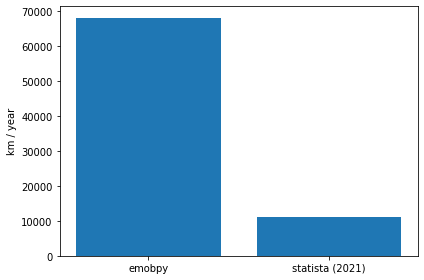

In [7]:
#average consumption of 200Wh per km  https://de.statista.com/statistik/daten/studie/183003/umfrage/pkw---gefahrene-kilometer-pro-jahr/, https://ev-database.de/cheatsheet/energy-consumption-electric-car 
#consumtion [kWh]  / 0.15 [kWh/km] 
#median in Germany is at about 11000 km per year

scale = 365/len(consumption_raw.resample("h").sum().index)
plot = plt.bar(
    ["emobpy", "statista (2021)"], [(consumption_raw.resample("h").sum()).sum().mean()*scale/ 0.16, 11000]
       )
plt.ylabel("km / year")
plt.tight_layout()

if V2G != True: plt.savefig(os.path.join(pics, 'annual_mileage.png'))

In [9]:
ts = power_raw.loc[(index.day<=7) & (index.month==1)].resample("12h").mean()


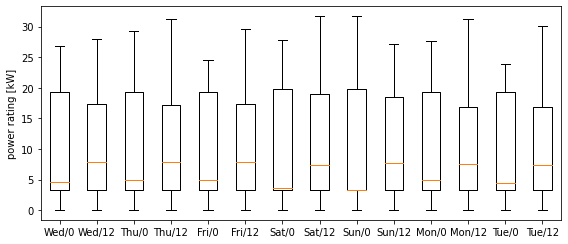

In [10]:
#power ratings are mostly between 3 and 20 kW 
fig, ax = plt.subplots(figsize=(8, 3.5))
ax.boxplot(
    ts.transpose(), labels= [d[:3] + "/" + str(h) for d, h in zip(ts.index.day_name(), ts.index.hour)],
      )

plt.ylabel('power rating [kW]')
fig.tight_layout()
#if V2G != True: plt.savefig(os.path.join(pics, 'average_power_rating.png'))

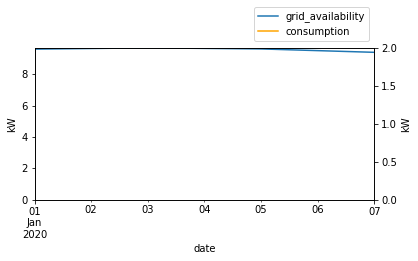

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

ts = power_raw.mean(1).resample("2D").mean()
ts_2 =  consumption_raw.mean(1).resample("2D").mean()

ax = ts.plot(ylabel="kW", label = "grid_availability")

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))

ax2 = ts_2.plot(ylabel="kW", color = "orange", label = "consumption")

#.loc[index.day<=7].resample("2h").
ax.set_ylim(0), ax2.set_ylim(0,2)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="best", bbox_to_anchor=(1,1.3))

ax.grid(axis="x")
fig.tight_layout()

#if V2G != True:  plt.savefig(os.path.join(pics, 'consumtion_power_availability.png'))

In [12]:
#https://www.agora-energiewende.de/en/service/recent-electricity-data/chart/power_generation/08.08.2021/08.08.2022/today/
german_peak = 73.3 #MW 30.11.2021
national_fleet_size = 10**6
scaling = national_fleet_size / consumption_raw.shape[0]
peak_load = consumption_raw.sum(1).nlargest(1).sum() #kW
print(peak_load) #kW 
print(peak_load*scaling*10**(-3) / german_peak) #kW --> MW

238768.4376574666
4847.342088479069


In [13]:
#plausibility:
#is the sum of the highest 10 consumption value assumed for one hour as constant lower than the average battery size?
(consumption_raw).mean(1).nlargest(10).sum() / car_properties_raw.iloc[2].mean()

2.545880067779877

def plot_step(df, consumption=True):
    df_ = df.copy()
    
    if type(df.index[0]) == int:
        df_.loc[df_.index[-1]+1,:] = df_.iloc[-1,:]
    else:
        df_.loc[str(pd.Timestamp(df_.index[-1] ) + 
                    pd.Timedelta(pd.infer_freq(index))),:
               ] = df_.iloc[-1,:]
        
    df_.index = pd.to_datetime(df_.index)
    
    fig, ax = plt.subplots(2)
    time_constrained=df_[df_.index.date <= df_.index[0].date()]
    x = time_constrained.index
    ax[0].step(x=x, y = time_constrained.iloc[:,2], where = "post")
    ax[1].step(x=x, y = time_constrained.sum(1).to_frame().rename(columns={0:"aggregated"}), where = "post")
    for i in [0,1]:
        ax[i].xaxis.set_major_locator(mdates.HourLocator())
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        if consumption == True: ax[i].set_ylabel("kWh/15min")
        else: ax[i].set_ylabel("kW")
        if i == 0: ax[i].set_title("one single profile")
        else: ax[i].set_title("aggregated profile")
        ax[i].set_xlabel("hour of the day")
        
        ax[i].set_ylim(bottom=0)
        
    fig.tight_layout()
    plt.show()


#plausibility check: energy charged is the same for both scenarios (if battery capacity is exceeded)
#solution_dict[car+str(i)]["m_early"]["charge"].sum() - solution_dict[car+str(i)]["m_early"]["discharge"].sum() - solution_dict[car+str(i)]["m_late"]["charge"].sum() + solution_dict[car+str(i)]["m_late"]["discharge"].sum()

#prepare variables and functions for optimization 
def plot_results(variable, car):
    observations = 400
    if variable == "charge":
        x = index[:observations]
        fig, ax = plt.subplots(4)
        ax[0].step(x, solution_dict[car]["m_late"]["charge"][:observations],  where = "mid")
        ax[0].set_title("late_charging")
        
        ax[1].step(x, solution_dict[car]["m_early"]["charge"][:observations],  where = "mid")
        ax[1].set_title("uncontrolled_charging")
        
        ax[2].step(x, solution_dict[car]["m_late"]["discharge"][:observations],  where = "mid")
        ax[2].set_title("late_discharging")
        
        ax[3].step(x, solution_dict[car]["m_early"]["discharge"][:observations],  where = "mid")
        ax[3].set_title("uncontrolled_discharging")
        for i in range(0,4):
            ax[i].set_ylabel("kW")
            ax[i].xaxis.set_major_locator(mdates.HourLocator(interval = 6))
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
            ax[i].set_ylabel("kW")
    else: 
        observations = observations + 1
        x = level_index[:(observations)]
        fig, ax = plt.subplots(3)
        ax[0].plot(x, solution_dict[car]["m_late"]["level"][:observations])
        ax[0].set_ylim(0, solution_dict[car]["m_early"]["level"].max())
        ax[0].set_title("late_level")
        
        ax[1].plot(x, solution_dict[car]["m_early"]["level"][:observations])
        ax[1].set_ylim(0, solution_dict[car]["m_early"]["level"].max())
        ax[1].set_title("uncontrolled_level")
        
        ax[2].plot(x, solution_dict[car]["level_differences"][:observations])
        ax[2].set_title("level_solution differences")
        ax[2].set_ylim(-solution_dict[car]["m_early"]["level"].max(),)
        
        for i in range(0,3):
            ax[i].set_ylabel("kWh")
    
            
            ax[i].xaxis.set_major_locator(mdates.HourLocator(interval = 6))
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

    
    plt.tight_layout()
    plt.show()


# EES-transformation: Generating uncontrolled and latest charging ts

In [14]:
#set same names for columns
power_raw.columns = consumption_raw.columns
neg_power_magnitude_raw.columns = consumption_raw.columns
car_properties_raw.columns = consumption_raw.columns

In [15]:
solution_dict = {}
ees_constraints= pd.DataFrame()
M = 10000
failed_profiles = []

count = 0
for car in consumption_raw.columns.unique():
    try: 
        car_list = consumption_raw[car].columns
    except AttributeError as a:
        car_list = [car]
        
    for i, c in enumerate(car_list):
        print(count)
        count =+ 1
        print(i) 
        print(c)
        
        if type(consumption_raw[c]) == pd.core.series.Series:
            consumption = consumption_raw[c]
            power = power_raw[car]
            neg_power_magnitude = neg_power_magnitude_raw[c]
            car_properties = car_properties_raw[c]

        else: 
            consumption = consumption_raw[c].iloc[:,i]
            power= power_raw[car].iloc[:,i]
            neg_power_magnitude= neg_power_magnitude_raw[c].iloc[:,i]
            car_properties= car_properties_raw[c].iloc[:,i]
            

        solution_dict[car+str(i)] = {}
        battery_capacity = car_properties.loc["battery_capacity"]
        level_0 = car_properties["soc_init"]*battery_capacity
        level_T = car_properties.loc["soc_end"]*battery_capacity

        for model_type in ["m_late","m_early"]:

            #Initialize model
            m = pyo.ConcreteModel()
            #initialize sets
            m.t = pyo.Set(initialize = index, ordered = True)

            #Initialize parameter
            m.consumption = pyo.Param(m.t, initialize=consumption.to_dict())
            m.power = pyo.Param(m.t, initialize=power.to_dict()) 
            m.neg_power = pyo.Param(m.t, initialize=neg_power_magnitude.to_dict()) 

            #Initialize variables
            m.CHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
            m.SLACK = pyo.Var(m.t, within = pyo.NonNegativeReals)
            m.DISCHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
            m.LEVEL = pyo.Var(m.t, within = pyo.NonNegativeReals, 
                              bounds = (0,battery_capacity))

            #level constraints
            def recursive_level(m, t):
                if t == index[0]:
                    return m.LEVEL[t] == level_0 + (m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )*step_duration
                else:    
                    return m.LEVEL[t] == m.LEVEL[pd.Timestamp(t) - 
                                                     pd.Timedelta(pd.infer_freq(index))] + (
                        m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )*step_duration   
            m.Recursive_level = pyo.Constraint(m.t, rule = recursive_level)

            def final_level(m, t):
                if t == index[-1]:
                    return m.LEVEL[t] == level_T
                else: 
                    return pyo.Constraint.Skip
            m.Final_level = pyo.Constraint(m.t, rule=final_level)
            
            #bidirectional charging 
            def neg_power_min(m, t):
                if V2G == True:
                    return m.DISCHARGE[t] <= m.neg_power[t] 
                else:
                    return m.DISCHARGE[t] ==0
            m.Neg_power_min_restriction = pyo.Constraint(m.t, rule=neg_power_min)

            def power_max(m, t):
                return m.CHARGE[t] <= m.power[t]   
            m.Power_max_restriction = pyo.Constraint(m.t, rule=power_max)
            
            def avoid_min_level(m, t):
                return m.LEVEL[t] + m.SLACK[t] >= battery_capacity*soc_min
            m.Avoid_min_level = pyo.Constraint(m.t, rule=avoid_min_level)
            
            def battery_level_sum(m, t):    
                if model_type == "m_late":
                    return sum(m.LEVEL[t] + M * m.SLACK[t] for t in m.t) 
                else:
                    return sum(m.LEVEL[t] for t in m.t) 
            if model_type == "m_late": sense = pyo.minimize
            else: sense = pyo.maximize
         
    
            m.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

            #find solver
            solvername='glpk'

            #prepare solver
            optimizer = opt.SolverFactory(solvername) 
            solved_model = optimizer.solve(m)      ##tee=True   

            if pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0][-1]== None:
                failed_profiles.append(car+str(i))
                print("failed")
            else:    
                print("succeeded")
                level_series = pd.concat([
                    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                    pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0]
                ], axis=0)
                charge_df = pd.DataFrame.from_dict(m.CHARGE.extract_values(), orient='index', columns = [car])
                discharge_df = pd.DataFrame.from_dict(m.DISCHARGE.extract_values(), orient='index', columns = [car])
            
                #store data in dictionary
                solution_dict[car+str(i)][model_type] = {}
                solution_dict[car+str(i)][model_type]["level"] = level_series
                solution_dict[car+str(i)][model_type]["charge"] = charge_df
                solution_dict[car+str(i)][model_type]["discharge"] = discharge_df
                level_index = solution_dict[car+str(i)][model_type]["level"].index
solution_dict["failed_profiles"] = failed_profiles

0
0
Audi/e-tron_55_quattro/2019
failed
failed
1
1
Audi/e-tron_55_quattro/2019
failed
failed
1
2
Audi/e-tron_55_quattro/2019
failed
failed
1
3
Audi/e-tron_55_quattro/2019
failed
failed
1
4
Audi/e-tron_55_quattro/2019
failed
failed
1
5
Audi/e-tron_55_quattro/2019
failed
failed
1
6
Audi/e-tron_55_quattro/2019
failed
failed
1
7
Audi/e-tron_55_quattro/2019
failed
failed
1
8
Audi/e-tron_55_quattro/2019
failed
failed
1
9
Audi/e-tron_55_quattro/2019
failed
failed
1
10
Audi/e-tron_55_quattro/2019
failed
failed
1
11
Audi/e-tron_55_quattro/2019
failed
failed
1
12
Audi/e-tron_55_quattro/2019
failed
failed
1
13
Audi/e-tron_55_quattro/2019
failed
failed
1
14
Audi/e-tron_55_quattro/2019
failed
failed
1
15
Audi/e-tron_55_quattro/2019
failed
failed
1
16
Audi/e-tron_55_quattro/2019
failed
failed
1
17
Audi/e-tron_55_quattro/2019
failed
failed
1
18
Audi/e-tron_55_quattro/2019
failed
failed
1
19
Audi/e-tron_55_quattro/2019
failed
failed
1
20
Audi/e-tron_55_quattro/2019
failed
failed
1
21
Audi/e-tron_55_qua

failed
failed
1
174
Audi/e-tron_55_quattro/2019
failed
failed
1
175
Audi/e-tron_55_quattro/2019
failed
failed
1
176
Audi/e-tron_55_quattro/2019
failed
failed
1
177
Audi/e-tron_55_quattro/2019
failed
failed
1
178
Audi/e-tron_55_quattro/2019
failed
failed
1
179
Audi/e-tron_55_quattro/2019
failed
failed
1
180
Audi/e-tron_55_quattro/2019
failed
failed
1
181
Audi/e-tron_55_quattro/2019
failed
failed
1
182
Audi/e-tron_55_quattro/2019
failed
failed
1
183
Audi/e-tron_55_quattro/2019
failed
failed
1
184
Audi/e-tron_55_quattro/2019
failed
failed
1
185
Audi/e-tron_55_quattro/2019
failed
failed
1
186
Audi/e-tron_55_quattro/2019
failed
failed
1
187
Audi/e-tron_55_quattro/2019
failed
failed
1
188
Audi/e-tron_55_quattro/2019
failed
failed
1
189
Audi/e-tron_55_quattro/2019
failed
failed
1
190
Audi/e-tron_55_quattro/2019
failed
failed
1
191
Audi/e-tron_55_quattro/2019
failed
failed
1
192
Audi/e-tron_55_quattro/2019
failed
failed
1
193
Audi/e-tron_55_quattro/2019
failed
failed
1
194
Audi/e-tron_55_quatt

failed
failed
1
345
Audi/e-tron_55_quattro/2019
failed
failed
1
346
Audi/e-tron_55_quattro/2019
failed
failed
1
347
Audi/e-tron_55_quattro/2019
failed
failed
1
348
Audi/e-tron_55_quattro/2019
failed
failed
1
349
Audi/e-tron_55_quattro/2019
failed
failed
1
350
Audi/e-tron_55_quattro/2019
failed
failed
1
351
Audi/e-tron_55_quattro/2019
failed
failed
1
352
Audi/e-tron_55_quattro/2019
failed
failed
1
353
Audi/e-tron_55_quattro/2019
failed
failed
1
354
Audi/e-tron_55_quattro/2019
failed
failed
1
355
Audi/e-tron_55_quattro/2019
failed
failed
1
356
Audi/e-tron_55_quattro/2019
failed
failed
1
357
Audi/e-tron_55_quattro/2019
failed
failed
1
358
Audi/e-tron_55_quattro/2019
failed
failed
1
359
Audi/e-tron_55_quattro/2019
failed
failed
1
360
Audi/e-tron_55_quattro/2019
failed
failed
1
361
Audi/e-tron_55_quattro/2019
failed
failed
1
362
Audi/e-tron_55_quattro/2019
failed
failed
1
363
Audi/e-tron_55_quattro/2019
failed
failed
1
364
Audi/e-tron_55_quattro/2019
failed
failed
1
365
Audi/e-tron_55_quatt

failed
failed
1
516
Audi/e-tron_55_quattro/2019
failed
failed
1
517
Audi/e-tron_55_quattro/2019
failed
failed
1
518
Audi/e-tron_55_quattro/2019
failed
failed
1
519
Audi/e-tron_55_quattro/2019
failed
failed
1
520
Audi/e-tron_55_quattro/2019
failed
failed
1
521
Audi/e-tron_55_quattro/2019
failed
failed
1
522
Audi/e-tron_55_quattro/2019
failed
failed
1
523
Audi/e-tron_55_quattro/2019
failed
failed
1
524
Audi/e-tron_55_quattro/2019
failed
failed
1
525
Audi/e-tron_55_quattro/2019
failed
failed
1
526
Audi/e-tron_55_quattro/2019
failed
failed
1
527
Audi/e-tron_55_quattro/2019
failed
failed
1
528
Audi/e-tron_55_quattro/2019
failed
failed
1
529
Audi/e-tron_55_quattro/2019
failed
failed
1
530
Audi/e-tron_55_quattro/2019
failed
failed
1
531
Audi/e-tron_55_quattro/2019
failed
failed
1
532
Audi/e-tron_55_quattro/2019
failed
failed
1
533
Audi/e-tron_55_quattro/2019
failed
failed
1
534
Audi/e-tron_55_quattro/2019
failed
failed
1
535
Audi/e-tron_55_quattro/2019
failed
failed
1
536
Audi/e-tron_55_quatt

failed
failed
1
687
Audi/e-tron_55_quattro/2019
failed
failed
1
688
Audi/e-tron_55_quattro/2019
failed
failed
1
689
Audi/e-tron_55_quattro/2019
failed
failed
1
690
Audi/e-tron_55_quattro/2019
failed
failed
1
691
Audi/e-tron_55_quattro/2019
failed
failed
1
692
Audi/e-tron_55_quattro/2019
failed
failed
1
693
Audi/e-tron_55_quattro/2019
failed
failed
1
694
Audi/e-tron_55_quattro/2019
failed
failed
1
695
Audi/e-tron_55_quattro/2019
failed
failed
1
696
Audi/e-tron_55_quattro/2019
failed
failed
1
697
Audi/e-tron_55_quattro/2019
failed
failed
1
698
Audi/e-tron_55_quattro/2019
failed
failed
1
699
Audi/e-tron_55_quattro/2019
failed
failed
1
700
Audi/e-tron_55_quattro/2019
failed
failed
1
701
Audi/e-tron_55_quattro/2019
failed
failed
1
702
Audi/e-tron_55_quattro/2019
failed
failed
1
703
Audi/e-tron_55_quattro/2019
failed
failed
1
704
Audi/e-tron_55_quattro/2019
failed
failed
1
705
Audi/e-tron_55_quattro/2019
failed
failed
1
706
Audi/e-tron_55_quattro/2019
failed
failed
1
707
Audi/e-tron_55_quatt

failed
failed
1
858
Audi/e-tron_55_quattro/2019
failed
failed
1
859
Audi/e-tron_55_quattro/2019
failed
failed
1
860
Audi/e-tron_55_quattro/2019
failed
failed
1
861
Audi/e-tron_55_quattro/2019
failed
failed
1
862
Audi/e-tron_55_quattro/2019
failed
failed
1
863
Audi/e-tron_55_quattro/2019
failed
failed
1
864
Audi/e-tron_55_quattro/2019
failed
failed
1
865
Audi/e-tron_55_quattro/2019
failed
failed
1
866
Audi/e-tron_55_quattro/2019
failed
failed
1
867
Audi/e-tron_55_quattro/2019
failed
failed
1
868
Audi/e-tron_55_quattro/2019
failed
failed
1
869
Audi/e-tron_55_quattro/2019
failed
failed
1
870
Audi/e-tron_55_quattro/2019
failed
failed
1
871
Audi/e-tron_55_quattro/2019
failed
failed
1
872
Audi/e-tron_55_quattro/2019
failed
failed
1
873
Audi/e-tron_55_quattro/2019
failed
failed
1
874
Audi/e-tron_55_quattro/2019
failed
failed
1
875
Audi/e-tron_55_quattro/2019
failed
failed
1
876
Audi/e-tron_55_quattro/2019
failed
failed
1
877
Audi/e-tron_55_quattro/2019
failed
failed
1
878
Audi/e-tron_55_quatt

failed
1
1028
Audi/e-tron_55_quattro/2019
failed
failed
1
1029
Audi/e-tron_55_quattro/2019
failed
failed
1
1030
Audi/e-tron_55_quattro/2019
failed
failed
1
1031
Audi/e-tron_55_quattro/2019
failed
failed
1
1032
Audi/e-tron_55_quattro/2019
failed
failed
1
1033
Audi/e-tron_55_quattro/2019
failed
failed
1
1034
Audi/e-tron_55_quattro/2019
failed
failed
1
1035
Audi/e-tron_55_quattro/2019
failed
failed
1
1036
Audi/e-tron_55_quattro/2019
failed
failed
1
1037
Audi/e-tron_55_quattro/2019
failed
failed
1
1038
Audi/e-tron_55_quattro/2019
failed
failed
1
1039
Audi/e-tron_55_quattro/2019
failed
failed
1
1040
Audi/e-tron_55_quattro/2019
failed
failed
1
1041
Audi/e-tron_55_quattro/2019
failed
failed
1
1042
Audi/e-tron_55_quattro/2019
failed
failed
1
1043
Audi/e-tron_55_quattro/2019
failed
failed
1
1044
Audi/e-tron_55_quattro/2019
failed
failed
1
1045
Audi/e-tron_55_quattro/2019
failed
failed
1
1046
Audi/e-tron_55_quattro/2019
failed
failed
1
1047
Audi/e-tron_55_quattro/2019
failed
failed
1
1048
Audi/e

failed
failed
1
1196
Audi/e-tron_55_quattro/2019
failed
failed
1
1197
Audi/e-tron_55_quattro/2019
failed
failed
1
1198
Audi/e-tron_55_quattro/2019
failed
failed
1
1199
Audi/e-tron_55_quattro/2019
failed
failed
1
1200
Audi/e-tron_55_quattro/2019
failed
failed
1
1201
Audi/e-tron_55_quattro/2019
failed
failed
1
1202
Audi/e-tron_55_quattro/2019
failed
failed
1
1203
Audi/e-tron_55_quattro/2019
failed
failed
1
1204
Audi/e-tron_55_quattro/2019
failed
failed
1
1205
Audi/e-tron_55_quattro/2019
failed
failed
1
1206
Audi/e-tron_55_quattro/2019
failed
failed
1
1207
Audi/e-tron_55_quattro/2019
failed
failed
1
1208
Audi/e-tron_55_quattro/2019
failed
failed
1
1209
Audi/e-tron_55_quattro/2019
failed
failed
1
1210
Audi/e-tron_55_quattro/2019
failed
failed
1
1211
Audi/e-tron_55_quattro/2019
failed
failed
1
1212
Audi/e-tron_55_quattro/2019
failed
failed
1
1213
Audi/e-tron_55_quattro/2019
failed
failed
1
1214
Audi/e-tron_55_quattro/2019
failed
failed
1
1215
Audi/e-tron_55_quattro/2019
failed
failed
1
1216

failed
failed
1
1364
Audi/e-tron_55_quattro/2019
failed
failed
1
1365
Audi/e-tron_55_quattro/2019
failed
failed
1
1366
Audi/e-tron_55_quattro/2019
failed
failed
1
1367
Audi/e-tron_55_quattro/2019
failed
failed
1
1368
Audi/e-tron_55_quattro/2019
failed
failed
1
1369
Audi/e-tron_55_quattro/2019
failed
failed
1
1370
Audi/e-tron_55_quattro/2019
failed
failed
1
1371
Audi/e-tron_55_quattro/2019
failed
failed
1
1372
Audi/e-tron_55_quattro/2019
failed
failed
1
1373
Audi/e-tron_55_quattro/2019
failed
failed
1
1374
Audi/e-tron_55_quattro/2019
failed
failed
1
1375
Audi/e-tron_55_quattro/2019
failed
failed
1
1376
Audi/e-tron_55_quattro/2019
failed
failed
1
1377
Audi/e-tron_55_quattro/2019
failed
failed
1
1378
Audi/e-tron_55_quattro/2019
failed
failed
1
1379
Audi/e-tron_55_quattro/2019
failed
failed
1
1380
Audi/e-tron_55_quattro/2019
failed
failed
1
1381
Audi/e-tron_55_quattro/2019
failed
failed
1
1382
Audi/e-tron_55_quattro/2019
failed
failed
1
1383
Audi/e-tron_55_quattro/2019
failed
failed
1
1384

failed
failed
1
1532
Audi/e-tron_55_quattro/2019
failed
failed
1
1533
Audi/e-tron_55_quattro/2019
failed
failed
1
1534
Audi/e-tron_55_quattro/2019
failed
failed
1
1535
Audi/e-tron_55_quattro/2019
failed
failed
1
1536
Audi/e-tron_55_quattro/2019
failed
failed
1
1537
Audi/e-tron_55_quattro/2019
failed
failed
1
1538
Audi/e-tron_55_quattro/2019
failed
failed
1
1539
Audi/e-tron_55_quattro/2019
failed
failed
1
1540
Audi/e-tron_55_quattro/2019
failed
failed
1
1541
Audi/e-tron_55_quattro/2019
failed
failed
1
1542
Audi/e-tron_55_quattro/2019
failed
failed
1
1543
Audi/e-tron_55_quattro/2019
failed
failed
1
1544
Audi/e-tron_55_quattro/2019
failed
failed
1
1545
Audi/e-tron_55_quattro/2019
failed
failed
1
1546
Audi/e-tron_55_quattro/2019
failed
failed
1
1547
Audi/e-tron_55_quattro/2019
failed
failed
1
1548
Audi/e-tron_55_quattro/2019
failed
failed
1
1549
Audi/e-tron_55_quattro/2019
failed
failed
1
1550
Audi/e-tron_55_quattro/2019
failed
failed
1
1551
Audi/e-tron_55_quattro/2019
failed
failed
1
1552

failed
failed
1
1700
Audi/e-tron_55_quattro/2019
failed
failed
1
1701
Audi/e-tron_55_quattro/2019
failed
failed
1
1702
Audi/e-tron_55_quattro/2019
failed
failed
1
1703
Audi/e-tron_55_quattro/2019
failed
failed
1
1704
Audi/e-tron_55_quattro/2019
failed
failed
1
1705
Audi/e-tron_55_quattro/2019
failed
failed
1
1706
Audi/e-tron_55_quattro/2019
failed
failed
1
1707
Audi/e-tron_55_quattro/2019
failed
failed
1
1708
Audi/e-tron_55_quattro/2019
failed
failed
1
1709
Audi/e-tron_55_quattro/2019
failed
failed
1
1710
Audi/e-tron_55_quattro/2019
failed
failed
1
1711
Audi/e-tron_55_quattro/2019
failed
failed
1
1712
Audi/e-tron_55_quattro/2019
failed
failed
1
1713
Audi/e-tron_55_quattro/2019
failed
failed
1
1714
Audi/e-tron_55_quattro/2019
failed
failed
1
1715
Audi/e-tron_55_quattro/2019
failed
failed
1
1716
Audi/e-tron_55_quattro/2019
failed
failed
1
1717
Audi/e-tron_55_quattro/2019
failed
failed
1
1718
Audi/e-tron_55_quattro/2019
failed
failed
1
1719
Audi/e-tron_55_quattro/2019
failed
failed
1
1720

failed
failed
1
1868
Audi/e-tron_55_quattro/2019
failed
failed
1
1869
Audi/e-tron_55_quattro/2019
failed
failed
1
1870
Audi/e-tron_55_quattro/2019
failed
failed
1
1871
Audi/e-tron_55_quattro/2019
failed
failed
1
1872
Audi/e-tron_55_quattro/2019
failed
failed
1
1873
Audi/e-tron_55_quattro/2019
failed
failed
1
1874
Audi/e-tron_55_quattro/2019
failed
failed
1
1875
Audi/e-tron_55_quattro/2019
failed
failed
1
1876
Audi/e-tron_55_quattro/2019
failed
failed
1
1877
Audi/e-tron_55_quattro/2019
failed
failed
1
1878
Audi/e-tron_55_quattro/2019
failed
failed
1
1879
Audi/e-tron_55_quattro/2019
failed
failed
1
1880
Audi/e-tron_55_quattro/2019
failed
failed
1
1881
Audi/e-tron_55_quattro/2019
failed
failed
1
1882
Audi/e-tron_55_quattro/2019
failed
failed
1
1883
Audi/e-tron_55_quattro/2019
failed
failed
1
1884
Audi/e-tron_55_quattro/2019
failed
failed
1
1885
Audi/e-tron_55_quattro/2019
failed
failed
1
1886
Audi/e-tron_55_quattro/2019
failed
failed
1
1887
Audi/e-tron_55_quattro/2019
failed
failed
1
1888

failed
1
2035
Audi/e-tron_55_quattro/2019
failed
failed
1
2036
Audi/e-tron_55_quattro/2019
failed
failed
1
2037
Audi/e-tron_55_quattro/2019
failed
failed
1
2038
Audi/e-tron_55_quattro/2019
failed
failed
1
2039
Audi/e-tron_55_quattro/2019
failed
failed
1
2040
Audi/e-tron_55_quattro/2019
failed
failed
1
2041
Audi/e-tron_55_quattro/2019
failed
failed
1
2042
Audi/e-tron_55_quattro/2019
failed
failed
1
2043
Audi/e-tron_55_quattro/2019
failed
failed
1
2044
Audi/e-tron_55_quattro/2019
failed
failed
1
2045
Audi/e-tron_55_quattro/2019
failed
failed
1
2046
Audi/e-tron_55_quattro/2019
failed
failed
1
2047
Audi/e-tron_55_quattro/2019
failed
failed
1
2048
Audi/e-tron_55_quattro/2019
failed
failed
1
2049
Audi/e-tron_55_quattro/2019
failed
failed
1
2050
Audi/e-tron_55_quattro/2019
failed
failed
1
2051
Audi/e-tron_55_quattro/2019
failed
failed
1
2052
Audi/e-tron_55_quattro/2019
failed
failed
1
2053
Audi/e-tron_55_quattro/2019
failed
failed
1
2054
Audi/e-tron_55_quattro/2019
failed
failed
1
2055
Audi/e

failed
failed
1
2203
Audi/e-tron_55_quattro/2019
failed
failed
1
2204
Audi/e-tron_55_quattro/2019
failed
failed
1
2205
Audi/e-tron_55_quattro/2019
failed
failed
1
2206
Audi/e-tron_55_quattro/2019
failed
failed
1
2207
Audi/e-tron_55_quattro/2019
failed
failed
1
2208
Audi/e-tron_55_quattro/2019
failed
failed
1
2209
Audi/e-tron_55_quattro/2019
failed
failed
1
2210
Audi/e-tron_55_quattro/2019
failed
failed
1
2211
Audi/e-tron_55_quattro/2019
failed
failed
1
2212
Audi/e-tron_55_quattro/2019
failed
failed
1
2213
Audi/e-tron_55_quattro/2019
failed
failed
1
2214
Audi/e-tron_55_quattro/2019
failed
failed
1
2215
Audi/e-tron_55_quattro/2019
failed
failed
1
2216
Audi/e-tron_55_quattro/2019
failed
failed
1
2217
Audi/e-tron_55_quattro/2019
failed
failed
1
2218
Audi/e-tron_55_quattro/2019
failed
failed
1
2219
Audi/e-tron_55_quattro/2019
failed
failed
1
2220
Audi/e-tron_55_quattro/2019
failed
failed
1
2221
Audi/e-tron_55_quattro/2019
failed
failed
1
2222
Audi/e-tron_55_quattro/2019
failed
failed
1
2223

failed
failed
1
2371
Audi/e-tron_55_quattro/2019
failed
failed
1
2372
Audi/e-tron_55_quattro/2019
failed
failed
1
2373
Audi/e-tron_55_quattro/2019
failed
failed
1
2374
Audi/e-tron_55_quattro/2019
failed
failed
1
2375
Audi/e-tron_55_quattro/2019
failed
failed
1
2376
Audi/e-tron_55_quattro/2019
failed
failed
1
2377
Audi/e-tron_55_quattro/2019
failed
failed
1
2378
Audi/e-tron_55_quattro/2019
failed
failed
1
2379
Audi/e-tron_55_quattro/2019
failed
failed
1
2380
Audi/e-tron_55_quattro/2019
failed
failed
1
2381
Audi/e-tron_55_quattro/2019
failed
failed
1
2382
Audi/e-tron_55_quattro/2019
failed
failed
1
2383
Audi/e-tron_55_quattro/2019
failed
failed
1
2384
Audi/e-tron_55_quattro/2019
failed
failed
1
2385
Audi/e-tron_55_quattro/2019
failed
failed
1
2386
Audi/e-tron_55_quattro/2019
failed
failed
1
2387
Audi/e-tron_55_quattro/2019
failed
failed
1
2388
Audi/e-tron_55_quattro/2019
failed
failed
1
2389
Audi/e-tron_55_quattro/2019
failed
failed
1
2390
Audi/e-tron_55_quattro/2019
failed
failed
1
2391

failed
failed
1
2539
Audi/e-tron_55_quattro/2019
failed
failed
1
2540
Audi/e-tron_55_quattro/2019
failed
failed
1
2541
Audi/e-tron_55_quattro/2019
failed
failed
1
2542
Audi/e-tron_55_quattro/2019
failed
failed
1
2543
Audi/e-tron_55_quattro/2019
failed
failed
1
2544
Audi/e-tron_55_quattro/2019
failed
failed
1
2545
Audi/e-tron_55_quattro/2019
failed
failed
1
2546
Audi/e-tron_55_quattro/2019
failed
failed
1
2547
Audi/e-tron_55_quattro/2019
failed
failed
1
2548
Audi/e-tron_55_quattro/2019
failed
failed
1
2549
Audi/e-tron_55_quattro/2019
failed
failed
1
2550
Audi/e-tron_55_quattro/2019
failed
failed
1
2551
Audi/e-tron_55_quattro/2019
failed
failed
1
2552
Audi/e-tron_55_quattro/2019
failed
failed
1
2553
Audi/e-tron_55_quattro/2019
failed
failed
1
2554
Audi/e-tron_55_quattro/2019
failed
failed
1
2555
Audi/e-tron_55_quattro/2019
failed
failed
1
2556
Audi/e-tron_55_quattro/2019
failed
failed
1
2557
Audi/e-tron_55_quattro/2019
failed
failed
1
2558
Audi/e-tron_55_quattro/2019
failed
failed
1
2559

failed
failed
1
2707
Audi/e-tron_55_quattro/2019
failed
failed
1
2708
Audi/e-tron_55_quattro/2019
failed
failed
1
2709
Audi/e-tron_55_quattro/2019
failed
failed
1
2710
Audi/e-tron_55_quattro/2019
failed
failed
1
2711
Audi/e-tron_55_quattro/2019
failed
failed
1
2712
Audi/e-tron_55_quattro/2019
failed
failed
1
2713
Audi/e-tron_55_quattro/2019
failed
failed
1
2714
Audi/e-tron_55_quattro/2019
failed
failed
1
2715
Audi/e-tron_55_quattro/2019
failed
failed
1
2716
Audi/e-tron_55_quattro/2019
failed
failed
1
2717
Audi/e-tron_55_quattro/2019
failed
failed
1
2718
Audi/e-tron_55_quattro/2019
failed
failed
1
2719
Audi/e-tron_55_quattro/2019
failed
failed
1
2720
Audi/e-tron_55_quattro/2019
failed
failed
1
2721
Audi/e-tron_55_quattro/2019
failed
failed
1
2722
Audi/e-tron_55_quattro/2019
failed
failed
1
2723
Audi/e-tron_55_quattro/2019
failed
failed
1
2724
Audi/e-tron_55_quattro/2019
failed
failed
1
2725
Audi/e-tron_55_quattro/2019
failed
failed
1
2726
Audi/e-tron_55_quattro/2019
failed
failed
1
2727

failed
failed
1
2875
Audi/e-tron_55_quattro/2019
failed
failed
1
2876
Audi/e-tron_55_quattro/2019
failed
failed
1
2877
Audi/e-tron_55_quattro/2019
failed
failed
1
2878
Audi/e-tron_55_quattro/2019
failed
failed
1
2879
Audi/e-tron_55_quattro/2019
failed
failed
1
2880
Audi/e-tron_55_quattro/2019
failed
failed
1
2881
Audi/e-tron_55_quattro/2019
failed
failed
1
2882
Audi/e-tron_55_quattro/2019
failed
failed
1
2883
Audi/e-tron_55_quattro/2019
failed
failed
1
2884
Audi/e-tron_55_quattro/2019
failed
failed
1
2885
Audi/e-tron_55_quattro/2019
failed
failed
1
2886
Audi/e-tron_55_quattro/2019
failed
failed
1
2887
Audi/e-tron_55_quattro/2019
failed
failed
1
2888
Audi/e-tron_55_quattro/2019
failed
failed
1
2889
Audi/e-tron_55_quattro/2019
failed
failed
1
2890
Audi/e-tron_55_quattro/2019
failed
failed
1
2891
Audi/e-tron_55_quattro/2019
failed
failed
1
2892
Audi/e-tron_55_quattro/2019
failed
failed
1
2893
Audi/e-tron_55_quattro/2019
failed
failed
1
2894
Audi/e-tron_55_quattro/2019
failed
failed
1
2895

failed
failed
1
3043
Audi/e-tron_55_quattro/2019
failed
failed
1
3044
Audi/e-tron_55_quattro/2019
failed
failed
1
3045
Audi/e-tron_55_quattro/2019
failed
failed
1
3046
Audi/e-tron_55_quattro/2019
failed
failed
1
3047
Audi/e-tron_55_quattro/2019
failed
failed
1
3048
Audi/e-tron_55_quattro/2019
failed
failed
1
3049
Audi/e-tron_55_quattro/2019
failed
failed
1
3050
Audi/e-tron_55_quattro/2019
failed
failed
1
3051
Audi/e-tron_55_quattro/2019
failed
failed
1
3052
Audi/e-tron_55_quattro/2019
failed
failed
1
3053
Audi/e-tron_55_quattro/2019
failed
failed
1
3054
Audi/e-tron_55_quattro/2019
failed
failed
1
3055
Audi/e-tron_55_quattro/2019
failed
failed
1
3056
Audi/e-tron_55_quattro/2019
failed
failed
1
3057
Audi/e-tron_55_quattro/2019
failed
failed
1
3058
Audi/e-tron_55_quattro/2019
failed
failed
1
3059
Audi/e-tron_55_quattro/2019
failed
failed
1
3060
Audi/e-tron_55_quattro/2019
failed
failed
1
3061
Audi/e-tron_55_quattro/2019
failed
failed
1
3062
Audi/e-tron_55_quattro/2019
failed
failed
1
3063

failed
failed
1
3211
Audi/e-tron_55_quattro/2019
failed
failed
1
3212
Audi/e-tron_55_quattro/2019
failed
failed
1
3213
Audi/e-tron_55_quattro/2019
failed
failed
1
3214
Audi/e-tron_55_quattro/2019
failed
failed
1
3215
Audi/e-tron_55_quattro/2019
failed
failed
1
3216
Audi/e-tron_55_quattro/2019
failed
failed
1
3217
Audi/e-tron_55_quattro/2019
failed
failed
1
3218
Audi/e-tron_55_quattro/2019
failed
failed
1
3219
Audi/e-tron_55_quattro/2019
failed
failed
1
3220
Audi/e-tron_55_quattro/2019
failed
failed
1
3221
Audi/e-tron_55_quattro/2019
failed
failed
1
3222
Audi/e-tron_55_quattro/2019
failed
failed
1
3223
Audi/e-tron_55_quattro/2019
failed
failed
1
3224
Audi/e-tron_55_quattro/2019
failed
failed
1
3225
Audi/e-tron_55_quattro/2019
failed
failed
1
3226
Audi/e-tron_55_quattro/2019
failed
failed
1
3227
Audi/e-tron_55_quattro/2019
failed
failed
1
3228
Audi/e-tron_55_quattro/2019
failed
failed
1
3229
Audi/e-tron_55_quattro/2019
failed
failed
1
3230
Audi/e-tron_55_quattro/2019
failed
failed
1
3231

succeeded
succeeded
1
3
FIAT/500e/2019
failed
failed
1
4
FIAT/500e/2019
failed
failed
1
5
FIAT/500e/2019
succeeded
succeeded
1
6
FIAT/500e/2019
succeeded
succeeded
1
7
FIAT/500e/2019
succeeded
succeeded
1
8
FIAT/500e/2019
succeeded
succeeded
1
9
FIAT/500e/2019
succeeded
succeeded
1
10
FIAT/500e/2019
succeeded
succeeded
1
11
FIAT/500e/2019
succeeded
succeeded
1
12
FIAT/500e/2019
succeeded
succeeded
1
13
FIAT/500e/2019
succeeded
succeeded
1
14
FIAT/500e/2019
succeeded
succeeded
1
15
FIAT/500e/2019
failed
failed
1
16
FIAT/500e/2019
succeeded
succeeded
1
17
FIAT/500e/2019
succeeded
succeeded
1
18
FIAT/500e/2019
succeeded
succeeded
1
19
FIAT/500e/2019
succeeded
succeeded
1
20
FIAT/500e/2019
succeeded
succeeded
1
21
FIAT/500e/2019
succeeded
succeeded
1
22
FIAT/500e/2019
succeeded
succeeded
1
23
FIAT/500e/2019
succeeded
succeeded
1
24
FIAT/500e/2019
succeeded
succeeded
1
25
FIAT/500e/2019
succeeded
succeeded
1
26
FIAT/500e/2019
succeeded
succeeded
1
27
FIAT/500e/2019
succeeded
succeeded
1
28


succeeded
1
83
BMW/i3_33_kWh/2017
succeeded
succeeded
1
84
BMW/i3_33_kWh/2017
succeeded
succeeded
1
85
BMW/i3_33_kWh/2017
succeeded
succeeded
1
86
BMW/i3_33_kWh/2017
succeeded
succeeded
1
87
BMW/i3_33_kWh/2017
succeeded
succeeded
1
88
BMW/i3_33_kWh/2017
succeeded
succeeded
1
89
BMW/i3_33_kWh/2017
failed
failed
1
0
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1
Renault/Zoe_Q90/2017
failed
failed
1
2
Renault/Zoe_Q90/2017
succeeded
succeeded
1
3
Renault/Zoe_Q90/2017
succeeded
succeeded
1
4
Renault/Zoe_Q90/2017
succeeded
succeeded
1
5
Renault/Zoe_Q90/2017
succeeded
succeeded
1
6
Renault/Zoe_Q90/2017
failed
failed
1
7
Renault/Zoe_Q90/2017
succeeded
succeeded
1
8
Renault/Zoe_Q90/2017
succeeded
succeeded
1
9
Renault/Zoe_Q90/2017
succeeded
succeeded
1
10
Renault/Zoe_Q90/2017
succeeded
succeeded
1
11
Renault/Zoe_Q90/2017
failed
failed
1
12
Renault/Zoe_Q90/2017
succeeded
succeeded
1
13
Renault/Zoe_Q90/2017
succeeded
succeeded
1
14
Renault/Zoe_Q90/2017
succeeded
succeeded
1
15
Renault/Zoe_Q90/2017


succeeded
succeeded
1
175
Renault/Zoe_Q90/2017
succeeded
succeeded
1
176
Renault/Zoe_Q90/2017
succeeded
succeeded
1
177
Renault/Zoe_Q90/2017
succeeded
succeeded
1
178
Renault/Zoe_Q90/2017
succeeded
succeeded
1
179
Renault/Zoe_Q90/2017
succeeded
succeeded
1
180
Renault/Zoe_Q90/2017
succeeded
succeeded
1
181
Renault/Zoe_Q90/2017
succeeded
succeeded
1
182
Renault/Zoe_Q90/2017
failed
failed
1
183
Renault/Zoe_Q90/2017
succeeded
succeeded
1
184
Renault/Zoe_Q90/2017
succeeded
succeeded
1
185
Renault/Zoe_Q90/2017
succeeded
succeeded
1
186
Renault/Zoe_Q90/2017
succeeded
succeeded
1
187
Renault/Zoe_Q90/2017
succeeded
succeeded
1
188
Renault/Zoe_Q90/2017
succeeded
succeeded
1
189
Renault/Zoe_Q90/2017
succeeded
succeeded
1
190
Renault/Zoe_Q90/2017
succeeded
succeeded
1
191
Renault/Zoe_Q90/2017
succeeded
succeeded
1
192
Renault/Zoe_Q90/2017
failed
failed
1
193
Renault/Zoe_Q90/2017
failed
failed
1
194
Renault/Zoe_Q90/2017
succeeded
succeeded
1
195
Renault/Zoe_Q90/2017
succeeded
succeeded
1
196
Renau

succeeded
succeeded
1
15
Hyundai/IONIQ_Electric_28_kWh/2019
failed
failed
1
16
Hyundai/IONIQ_Electric_28_kWh/2019
succeeded
succeeded
1
17
Hyundai/IONIQ_Electric_28_kWh/2019
succeeded
succeeded
1
18
Hyundai/IONIQ_Electric_28_kWh/2019
succeeded
succeeded
1
19
Hyundai/IONIQ_Electric_28_kWh/2019
succeeded
succeeded
1
20
Hyundai/IONIQ_Electric_28_kWh/2019
succeeded
succeeded
1
21
Hyundai/IONIQ_Electric_28_kWh/2019
failed
failed
1
22
Hyundai/IONIQ_Electric_28_kWh/2019
succeeded
succeeded
1
23
Hyundai/IONIQ_Electric_28_kWh/2019
succeeded
succeeded
1
24
Hyundai/IONIQ_Electric_28_kWh/2019
succeeded
succeeded
1
25
Hyundai/IONIQ_Electric_28_kWh/2019
succeeded
succeeded
1
26
Hyundai/IONIQ_Electric_28_kWh/2019
succeeded
succeeded
1
27
Hyundai/IONIQ_Electric_28_kWh/2019
succeeded
succeeded
1
28
Hyundai/IONIQ_Electric_28_kWh/2019
failed
failed
1
29
Hyundai/IONIQ_Electric_28_kWh/2019
failed
failed
1
30
Hyundai/IONIQ_Electric_28_kWh/2019
succeeded
succeeded
1
31
Hyundai/IONIQ_Electric_28_kWh/2019
fail

failed
failed
1
124
Volkswagen/ID.3/2020
succeeded
succeeded
1
125
Volkswagen/ID.3/2020
succeeded
succeeded
1
126
Volkswagen/ID.3/2020
succeeded
succeeded
1
127
Volkswagen/ID.3/2020
succeeded
succeeded
1
128
Volkswagen/ID.3/2020
failed
failed
1
129
Volkswagen/ID.3/2020
succeeded
succeeded
1
130
Volkswagen/ID.3/2020
succeeded
succeeded
1
131
Volkswagen/ID.3/2020
succeeded
succeeded
1
132
Volkswagen/ID.3/2020
succeeded
succeeded
1
133
Volkswagen/ID.3/2020
succeeded
succeeded
1
134
Volkswagen/ID.3/2020
failed
failed
1
135
Volkswagen/ID.3/2020
succeeded
succeeded
1
136
Volkswagen/ID.3/2020
succeeded
succeeded
1
137
Volkswagen/ID.3/2020
succeeded
succeeded
1
138
Volkswagen/ID.3/2020
succeeded
succeeded
1
139
Volkswagen/ID.3/2020
failed
failed
1
140
Volkswagen/ID.3/2020
succeeded
succeeded
1
141
Volkswagen/ID.3/2020
succeeded
succeeded
1
142
Volkswagen/ID.3/2020
succeeded
succeeded
1
143
Volkswagen/ID.3/2020
succeeded
succeeded
1
144
Volkswagen/ID.3/2020
succeeded
succeeded
1
145
Volkswagen/

succeeded
succeeded
1
302
Volkswagen/ID.3/2020
succeeded
succeeded
1
303
Volkswagen/ID.3/2020
succeeded
succeeded
1
304
Volkswagen/ID.3/2020
succeeded
succeeded
1
305
Volkswagen/ID.3/2020
succeeded
succeeded
1
306
Volkswagen/ID.3/2020
failed
failed
1
307
Volkswagen/ID.3/2020
succeeded
succeeded
1
308
Volkswagen/ID.3/2020
succeeded
succeeded
1
309
Volkswagen/ID.3/2020
failed
failed
1
310
Volkswagen/ID.3/2020
succeeded
succeeded
1
311
Volkswagen/ID.3/2020
succeeded
succeeded
1
312
Volkswagen/ID.3/2020
succeeded
succeeded
1
313
Volkswagen/ID.3/2020
failed
failed
1
314
Volkswagen/ID.3/2020
succeeded
succeeded
1
315
Volkswagen/ID.3/2020
succeeded
succeeded
1
316
Volkswagen/ID.3/2020
succeeded
succeeded
1
317
Volkswagen/ID.3/2020
failed
failed
1
318
Volkswagen/ID.3/2020
succeeded
succeeded
1
319
Volkswagen/ID.3/2020
succeeded
succeeded
1
320
Volkswagen/ID.3/2020
succeeded
succeeded
1
321
Volkswagen/ID.3/2020
succeeded
succeeded
1
322
Volkswagen/ID.3/2020
succeeded
succeeded
1
323
Volkswagen/

succeeded
succeeded
1
481
Volkswagen/ID.3/2020
failed
failed
1
482
Volkswagen/ID.3/2020
succeeded
succeeded
1
483
Volkswagen/ID.3/2020
succeeded
succeeded
1
484
Volkswagen/ID.3/2020
succeeded
succeeded
1
485
Volkswagen/ID.3/2020
failed
failed
1
486
Volkswagen/ID.3/2020
succeeded
succeeded
1
487
Volkswagen/ID.3/2020
failed
failed
1
488
Volkswagen/ID.3/2020
succeeded
succeeded
1
489
Volkswagen/ID.3/2020
succeeded
succeeded
1
490
Volkswagen/ID.3/2020
succeeded
succeeded
1
491
Volkswagen/ID.3/2020
succeeded
succeeded
1
492
Volkswagen/ID.3/2020
succeeded
succeeded
1
493
Volkswagen/ID.3/2020
succeeded
succeeded
1
494
Volkswagen/ID.3/2020
succeeded
succeeded
1
495
Volkswagen/ID.3/2020
succeeded
succeeded
1
496
Volkswagen/ID.3/2020
succeeded
succeeded
1
497
Volkswagen/ID.3/2020
succeeded
succeeded
1
498
Volkswagen/ID.3/2020
succeeded
succeeded
1
499
Volkswagen/ID.3/2020
succeeded
succeeded
1
500
Volkswagen/ID.3/2020
succeeded
succeeded
1
501
Volkswagen/ID.3/2020
succeeded
succeeded
1
502
Volks

succeeded
1
660
Volkswagen/ID.3/2020
succeeded
succeeded
1
661
Volkswagen/ID.3/2020
succeeded
succeeded
1
662
Volkswagen/ID.3/2020
succeeded
succeeded
1
663
Volkswagen/ID.3/2020
succeeded
succeeded
1
664
Volkswagen/ID.3/2020
succeeded
succeeded
1
665
Volkswagen/ID.3/2020
succeeded
succeeded
1
666
Volkswagen/ID.3/2020
failed
failed
1
667
Volkswagen/ID.3/2020
succeeded
succeeded
1
668
Volkswagen/ID.3/2020
succeeded
succeeded
1
669
Volkswagen/ID.3/2020
failed
failed
1
670
Volkswagen/ID.3/2020
failed
failed
1
671
Volkswagen/ID.3/2020
failed
failed
1
672
Volkswagen/ID.3/2020
failed
failed
1
673
Volkswagen/ID.3/2020
succeeded
succeeded
1
674
Volkswagen/ID.3/2020
succeeded
succeeded
1
675
Volkswagen/ID.3/2020
succeeded
succeeded
1
676
Volkswagen/ID.3/2020
succeeded
succeeded
1
677
Volkswagen/ID.3/2020
succeeded
succeeded
1
678
Volkswagen/ID.3/2020
succeeded
succeeded
1
679
Volkswagen/ID.3/2020
succeeded
succeeded
1
680
Volkswagen/ID.3/2020
succeeded
succeeded
1
681
Volkswagen/ID.3/2020
succee

succeeded
1
840
Volkswagen/ID.3/2020
succeeded
succeeded
1
841
Volkswagen/ID.3/2020
succeeded
succeeded
1
842
Volkswagen/ID.3/2020
succeeded
succeeded
1
843
Volkswagen/ID.3/2020
succeeded
succeeded
1
844
Volkswagen/ID.3/2020
failed
failed
1
845
Volkswagen/ID.3/2020
succeeded
succeeded
1
846
Volkswagen/ID.3/2020
succeeded
succeeded
1
847
Volkswagen/ID.3/2020
succeeded
succeeded
1
848
Volkswagen/ID.3/2020
succeeded
succeeded
1
849
Volkswagen/ID.3/2020
succeeded
succeeded
1
850
Volkswagen/ID.3/2020
succeeded
succeeded
1
851
Volkswagen/ID.3/2020
succeeded
succeeded
1
852
Volkswagen/ID.3/2020
succeeded
succeeded
1
853
Volkswagen/ID.3/2020
succeeded
succeeded
1
854
Volkswagen/ID.3/2020
succeeded
succeeded
1
855
Volkswagen/ID.3/2020
succeeded
succeeded
1
856
Volkswagen/ID.3/2020
failed
failed
1
857
Volkswagen/ID.3/2020
succeeded
succeeded
1
858
Volkswagen/ID.3/2020
succeeded
succeeded
1
859
Volkswagen/ID.3/2020
failed
failed
1
860
Volkswagen/ID.3/2020
succeeded
succeeded
1
861
Volkswagen/ID.3

succeeded
succeeded
1
1018
Volkswagen/ID.3/2020
succeeded
succeeded
1
1019
Volkswagen/ID.3/2020
succeeded
succeeded
1
1020
Volkswagen/ID.3/2020
succeeded
succeeded
1
1021
Volkswagen/ID.3/2020
succeeded
succeeded
1
1022
Volkswagen/ID.3/2020
succeeded
succeeded
1
1023
Volkswagen/ID.3/2020
failed
failed
1
1024
Volkswagen/ID.3/2020
succeeded
succeeded
1
1025
Volkswagen/ID.3/2020
failed
failed
1
1026
Volkswagen/ID.3/2020
failed
failed
1
1027
Volkswagen/ID.3/2020
succeeded
succeeded
1
1028
Volkswagen/ID.3/2020
succeeded
succeeded
1
1029
Volkswagen/ID.3/2020
succeeded
succeeded
1
1030
Volkswagen/ID.3/2020
succeeded
succeeded
1
1031
Volkswagen/ID.3/2020
succeeded
succeeded
1
1032
Volkswagen/ID.3/2020
failed
failed
1
1033
Volkswagen/ID.3/2020
succeeded
succeeded
1
1034
Volkswagen/ID.3/2020
succeeded
succeeded
1
1035
Volkswagen/ID.3/2020
succeeded
succeeded
1
1036
Volkswagen/ID.3/2020
succeeded
succeeded
1
1037
Volkswagen/ID.3/2020
succeeded
succeeded
1
1038
Volkswagen/ID.3/2020
succeeded
succee

succeeded
succeeded
1
1192
Volkswagen/ID.3/2020
failed
failed
1
1193
Volkswagen/ID.3/2020
succeeded
succeeded
1
1194
Volkswagen/ID.3/2020
failed
failed
1
1195
Volkswagen/ID.3/2020
succeeded
succeeded
1
1196
Volkswagen/ID.3/2020
succeeded
succeeded
1
1197
Volkswagen/ID.3/2020
succeeded
succeeded
1
1198
Volkswagen/ID.3/2020
succeeded
succeeded
1
1199
Volkswagen/ID.3/2020
succeeded
succeeded
1
1200
Volkswagen/ID.3/2020
succeeded
succeeded
1
1201
Volkswagen/ID.3/2020
failed
failed
1
1202
Volkswagen/ID.3/2020
failed
failed
1
1203
Volkswagen/ID.3/2020
succeeded
succeeded
1
1204
Volkswagen/ID.3/2020
succeeded
succeeded
1
1205
Volkswagen/ID.3/2020
succeeded
succeeded
1
1206
Volkswagen/ID.3/2020
succeeded
succeeded
1
1207
Volkswagen/ID.3/2020
succeeded
succeeded
1
1208
Volkswagen/ID.3/2020
succeeded
succeeded
1
1209
Volkswagen/ID.3/2020
succeeded
succeeded
1
1210
Volkswagen/ID.3/2020
succeeded
succeeded
1
1211
Volkswagen/ID.3/2020
succeeded
succeeded
1
1212
Volkswagen/ID.3/2020
succeeded
succee

succeeded
1
1366
Volkswagen/ID.3/2020
succeeded
succeeded
1
1367
Volkswagen/ID.3/2020
succeeded
succeeded
1
1368
Volkswagen/ID.3/2020
succeeded
succeeded
1
1369
Volkswagen/ID.3/2020
succeeded
succeeded
1
1370
Volkswagen/ID.3/2020
succeeded
succeeded
1
1371
Volkswagen/ID.3/2020
succeeded
succeeded
1
1372
Volkswagen/ID.3/2020
succeeded
succeeded
1
1373
Volkswagen/ID.3/2020
succeeded
succeeded
1
1374
Volkswagen/ID.3/2020
failed
failed
1
1375
Volkswagen/ID.3/2020
succeeded
succeeded
1
1376
Volkswagen/ID.3/2020
succeeded
succeeded
1
1377
Volkswagen/ID.3/2020
succeeded
succeeded
1
1378
Volkswagen/ID.3/2020
succeeded
succeeded
1
1379
Volkswagen/ID.3/2020
succeeded
succeeded
1
1380
Volkswagen/ID.3/2020
succeeded
succeeded
1
1381
Volkswagen/ID.3/2020
succeeded
succeeded
1
1382
Volkswagen/ID.3/2020
succeeded
succeeded
1
1383
Volkswagen/ID.3/2020
succeeded
succeeded
1
1384
Volkswagen/ID.3/2020
succeeded
succeeded
1
1385
Volkswagen/ID.3/2020
succeeded
succeeded
1
1386
Volkswagen/ID.3/2020
failed
f

succeeded
succeeded
1
22
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
23
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
24
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
25
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
26
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
27
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
28
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
29
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
30
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
31
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
32
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
33
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
34
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
35
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
36
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
37
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
38
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succe

failed
failed
1
162
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
163
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
164
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
165
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
166
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
167
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
168
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
169
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
170
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
171
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
172
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
173
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
174
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
175
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
176
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
177
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
178
Tesla/Model_3_Long_Range_AWD/2019
succeeded


succeeded
succeeded
1
301
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
302
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
303
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
304
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
305
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
306
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
307
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
308
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
309
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
310
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
311
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
312
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
313
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
314
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
315
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
316
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
317
Tesla/Model_3_Long_R

succeeded
succeeded
1
440
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
441
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
442
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
443
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
444
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
445
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
446
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
447
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
448
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
449
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
450
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
451
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
452
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
453
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
454
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
455
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
456
Tesla/Model_3_

succeeded
succeeded
1
578
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
579
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
580
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
581
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
582
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
583
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
584
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
585
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
586
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
587
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
588
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
589
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
590
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
591
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
592
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
593
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
594
Tesla/Model_3_Long_Range_AWD/201

succeeded
succeeded
1
717
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
718
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
719
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
720
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
721
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
722
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
723
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
724
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
725
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
726
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
727
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
728
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
729
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
730
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
731
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
732
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
733
Tesla/Model_3_

succeeded
succeeded
1
856
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
857
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
858
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
859
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
860
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
861
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
862
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
863
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
864
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
865
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
866
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
867
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
868
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
869
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
870
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
871
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
872
Tesla/Model_3_Long_Range_A

succeeded
succeeded
1
995
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
996
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
997
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
998
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
999
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1000
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1001
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1002
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1003
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1004
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1005
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1006
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1007
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1008
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1009
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1010
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1011
Tesla/Model_3_Long_R

succeeded
succeeded
1
1132
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1133
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1134
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1135
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1136
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1137
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1138
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1139
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1140
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1141
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1142
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1143
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1144
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1145
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1146
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1147
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1148
Tesla/Model_3_L

succeeded
succeeded
1
1269
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1270
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1271
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1272
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1273
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1274
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1275
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1276
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1277
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1278
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1279
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1280
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1281
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1282
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1283
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1284
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1285
Tesla/Model_3_L

succeeded
succeeded
1
1406
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1407
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1408
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1409
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1410
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1411
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1412
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1413
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1414
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1415
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1416
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1417
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1418
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1419
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1420
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1421
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1422
Tes

succeeded
succeeded
1
1542
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1543
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1544
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1545
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1546
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1547
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1548
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1549
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1550
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1551
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1552
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1553
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1554
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1555
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1556
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1557
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1558
Tesla/Model_3_L

succeeded
succeeded
1
1678
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1679
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1680
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1681
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1682
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1683
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1684
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1685
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1686
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1687
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1688
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1689
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1690
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1691
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1692
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1693
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1694
Tesla/Model_3_Long_Range_AW

succeeded
succeeded
1
1815
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1816
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1817
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1818
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1819
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1820
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1821
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1822
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1823
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1824
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1825
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1826
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1827
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1828
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1829
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1830
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1831
Tesla/Mod

failed
failed
1
1952
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1953
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1954
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1955
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1956
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1957
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1958
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1959
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1960
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1961
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
1962
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1963
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1964
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1965
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1966
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1967
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1968
Tesla/Mod

succeeded
succeeded
1
2088
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2089
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2090
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2091
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2092
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2093
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2094
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2095
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2096
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2097
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2098
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2099
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2100
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2101
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2102
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2103
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2104
Tesla/Model_3_L

succeeded
succeeded
1
2225
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2226
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2227
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2228
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2229
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2230
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2231
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2232
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2233
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2234
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2235
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2236
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2237
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2238
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2239
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2240
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2241
Tesla/Model_3_Long_Ra

succeeded
1
2361
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2362
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2363
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2364
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2365
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2366
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2367
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2368
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2369
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2370
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2371
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2372
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2373
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2374
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2375
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2376
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2377
Tesla/Model_3

succeeded
1
2497
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2498
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2499
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2500
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2501
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2502
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2503
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2504
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2505
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2506
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2507
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2508
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2509
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2510
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2511
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2512
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2513
Tesla/Model_3

succeeded
succeeded
1
2633
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2634
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2635
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2636
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2637
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2638
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2639
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2640
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2641
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2642
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2643
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2644
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2645
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2646
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2647
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2648
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2649
Tesla/Mod

succeeded
succeeded
1
2769
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2770
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2771
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2772
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2773
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2774
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2775
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2776
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2777
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2778
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2779
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2780
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2781
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2782
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2783
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2784
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
27

succeeded
succeeded
1
2905
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2906
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2907
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2908
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2909
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2910
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2911
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2912
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2913
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2914
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2915
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2916
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2917
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2918
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
2919
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2920
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2921
Tesla/Mod

succeeded
succeeded
1
3042
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3043
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3044
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3045
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3046
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3047
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3048
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3049
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3050
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3051
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3052
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3053
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3054
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3055
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3056
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3057
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3058
Tesla/Mod

succeeded
succeeded
1
3179
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3180
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3181
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3182
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3183
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3184
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3185
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3186
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3187
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3188
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3189
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3190
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3191
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3192
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3193
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3194
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3195
Tesla/Model_3_L

succeeded
succeeded
1
3316
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3317
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3318
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3319
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3320
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3321
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3322
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3323
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3324
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3325
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3326
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3327
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3328
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3329
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3330
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3331
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3332
Tesla/Model_3_L

succeeded
succeeded
1
3453
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3454
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3455
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3456
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3457
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3458
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3459
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3460
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3461
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3462
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3463
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3464
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3465
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3466
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3467
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3468
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
34

succeeded
succeeded
1
3591
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3592
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3593
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3594
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3595
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3596
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3597
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3598
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3599
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3600
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3601
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3602
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3603
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3604
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3605
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3606
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3607
Tesla/Mod

succeeded
succeeded
1
3729
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3730
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3731
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3732
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3733
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3734
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3735
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3736
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3737
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3738
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3739
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3740
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3741
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3742
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3743
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3744
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3745
Tesla/Mod

succeeded
succeeded
1
3866
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3867
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3868
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3869
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
3870
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3871
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3872
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3873
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3874
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3875
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3876
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3877
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3878
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3879
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3880
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3881
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3882
Tesla/Mod

failed
failed
1
4002
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4003
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4004
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4005
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4006
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4007
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4008
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4009
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4010
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4011
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4012
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4013
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4014
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4015
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4016
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4017
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4018
Tesla/Model_3_L

succeeded
succeeded
1
4139
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4140
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4141
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4142
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4143
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4144
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4145
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4146
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4147
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4148
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4149
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4150
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4151
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4152
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4153
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4154
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4155
Tesla/Mod

succeeded
succeeded
1
4275
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4276
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4277
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4278
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4279
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4280
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4281
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4282
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4283
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4284
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4285
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4286
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4287
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4288
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4289
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4290
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4291
Tes

succeeded
succeeded
1
4412
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4413
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4414
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4415
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4416
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4417
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4418
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4419
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4420
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4421
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4422
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4423
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4424
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4425
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4426
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4427
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4428
Tesla/Model_3_L

succeeded
succeeded
1
4549
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4550
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4551
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4552
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4553
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4554
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4555
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4556
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4557
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4558
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4559
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4560
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4561
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4562
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4563
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4564
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4565
Tes

succeeded
succeeded
1
4685
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4686
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4687
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4688
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4689
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4690
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4691
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4692
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4693
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4694
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4695
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4696
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4697
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4698
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4699
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4700
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4701
Tesla/Model_3_L

succeeded
succeeded
1
4821
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4822
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4823
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4824
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4825
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4826
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4827
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4828
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4829
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4830
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4831
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4832
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4833
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4834
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4835
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4836
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4837
Tes

succeeded
succeeded
1
4957
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4958
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4959
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4960
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4961
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4962
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4963
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4964
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4965
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4966
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4967
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4968
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4969
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4970
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4971
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
4972
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4973
Tesla/Model_3_L

failed
failed
1
5094
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
5095
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5096
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
5097
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5098
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5099
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5100
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5101
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5102
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5103
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5104
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5105
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5106
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
5107
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5108
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5109
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5110
Tesla/Model_3_Long_Ra

succeeded
succeeded
1
5231
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5232
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
5233
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5234
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5235
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5236
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5237
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5238
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5239
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5240
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5241
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5242
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5243
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5244
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5245
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5246
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5247
Tes

succeeded
succeeded
1
5368
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5369
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5370
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
5371
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5372
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5373
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5374
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5375
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5376
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5377
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5378
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5379
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5380
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
5381
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5382
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5383
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5384
Tesla/Mod

succeeded
succeeded
1
5504
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5505
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
5506
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5507
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
5508
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5509
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5510
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5511
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5512
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5513
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5514
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5515
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5516
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5517
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5518
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5519
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5520
Tesla/Mod

succeeded
1
5640
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5641
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
5642
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5643
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5644
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5645
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5646
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5647
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5648
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5649
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5650
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5651
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5652
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5653
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5654
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5655
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5656
Tesla/Model_3

succeeded
succeeded
1
5776
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5777
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5778
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5779
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5780
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5781
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
5782
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5783
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5784
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5785
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5786
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5787
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5788
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5789
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
5790
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5791
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5792
Tesla/Mod

succeeded
succeeded
1
5913
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5914
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5915
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5916
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5917
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5918
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5919
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5920
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5921
Tesla/Model_3_Long_Range_AWD/2019
failed
failed
1
5922
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5923
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5924
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5925
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5926
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5927
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5928
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
5929
Tes

In [16]:
if V2G: mode = "V2G" 
else: mode = "G2V"
    
with open(f'{short_or_long}_solution_dict_{mode}.pickle', 'wb') as handle:
    pickle.dump(solution_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open(f'{short_or_long}_solution_dict_{mode}.pickle', 'rb') as handle:
 #   solution_dict = pickle.load(handle)

## Processing EES-profiles: Aggregation

In [ ]:
uncontrolled_level_accurate, uncontrolled_charge_df, early, late = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),pd.DataFrame()
df_con, df_pow, df_neg_pow, df_pro =  pd.DataFrame(), pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

count = 0
for c in consumption_raw.columns.unique():
    try: 
        car_list = consumption_raw[c].columns
    except AttributeError as a:
        car_list = [c]

    for i, car in enumerate(car_list):
        if car+str(i) not in solution_dict["failed_profiles"] :
            print(count)
            if type(consumption_raw[car]) == pd.core.series.Series: 
                df_con[car] = consumption_raw[car]
                df_pow[car] = power_raw[car]
                df_neg_pow[car] = neg_power_magnitude_raw[car]
                df_pro[car] = car_properties_raw[car]
            else: 
                df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
                df_pow[car+str(i)] = power_raw[car].iloc[:,i]
                df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
                df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
            try: 
                early = pd.concat([
                    early, solution_dict[car+str(i)]["m_early"]["level"]
                ], axis=1).sum(1)
                late = pd.concat([
                   late, solution_dict[car+str(i)]["m_late"]["level"]
                ], axis=1).sum(1)
                uncontrolled_charge_df = pd.concat([
                    uncontrolled_charge_df, solution_dict[car+str(i)]["m_early"]["charge"]
                ], axis=1)

                count += 1
            except KeyError: 
                pass

level_0_agg = sum(df_pro.loc["soc_init"]*df_pro.loc["battery_capacity"])
level_T_agg = sum(df_pro.loc["soc_end"]*df_pro.loc["battery_capacity"])   

uncontrolled_level_accurate = early
uncontrolled_level_accurate.iloc[0] = level_0_agg ##
uncontrolled_level_accurate.name = "uncontrolled_level"

uncontrolled_charge_accurate = uncontrolled_charge_df.sum(1)

uncontrolled_charge_accurate.name = "uncontrolled_charge"        
ees_constraints_aggergated=late-early

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

102
103
104
105
106
107
108
109
110


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

111
112
113
114
115
116
117
118
119


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

120
121
122
123
124
125
126
127
128


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

129
130
131
132
133
134
135
136
137


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

138
139
140
141
142
143
144
145
146


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

147
148
149
150
151
152
153
154


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

155
156
157
158
159
160
161
162


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

163
164
165
166
167
168
169
170


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

171
172
173
174
175
176
177
178


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

179
180
181
182
183
184
185


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

186
187
188
189
190
191
192
193
194


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

195
196
197
198
199
200
201
202
203


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

204
205
206
207
208
209
210
211


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

212
213
214
215
216
217
218
219


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

220
221
222
223
224
225
226
227
228


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

229
230
231
232
233
234
235


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

236
237
238
239
240
241


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

242
243
244
245
246
247
248


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

249
250
251
252
253


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

254
255
256
257
258
259


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

260
261
262
263
264
265


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

266
267
268
269
270
271


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

272
273
274
275
276
277


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

278
279
280
281
282
283
284


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

285
286
287
288
289
290
291
292
293
294
295
296


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

297
298
299
300
301
302


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

303
304
305
306
307
308


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

309
310
311
312
313


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

314
315
316
317
318
319
320
321
322
323
324


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

325
326
327
328
329
330


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

331
332
333
334
335
336
337


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

338
339
340
341
342
343


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

344
345
346
347
348
349


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

350
351
352
353
354
355


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

356
357
358
359
360
361


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

362
363
364
365
366
367


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

368
369
370
371
372


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

373
374
375
376
377
378


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

379
380
381
382
383
384


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

385
386
387
388
389
390


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

391
392
393
394
395
396


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

397
398
399
400
401


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

402
403
404
405
406
407


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

408
409
410
411
412
413


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

414
415
416
417
418
419


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

420
421
422
423
424
425


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

426
427
428
429
430
431
432


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

433
434
435
436
437
438
439


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

440
441
442
443
444
445
446
447
448
449
450
451
452


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

453
454
455
456
457
458
459


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

460
461
462
463
464


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

465
466
467
468
469


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

470
471
472
473
474
475
476


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

477
478
479
480
481
482
483


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

484
485
486
487
488
489


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

490
491
492
493
494
495
496
497


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

498
499
500
501
502
503


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

504
505
506
507
508
509


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

510
511
512
513
514
515


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

516
517
518
519
520
521
522


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

523
524
525
526
527
528


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

529
530
531
532
533
534


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

535
536
537
538
539


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

540
541
542
543
544
545


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

546
547
548
549
550


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

551
552
553


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

554
555
556


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

557
558


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

559
560
561


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

562
563
564


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

565
566
567


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

568
569
570


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

571
572
573


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

574
575
576


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

577
578
579


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

580
581
582


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

583
584
585


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

586
587
588


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

589
590
591


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

592
593
594


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

595
596
597


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

598
599
600


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

601
602
603


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

604
605
606


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

607
608


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

609
610
611


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

612
613
614


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

615
616
617


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

618
619
620


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

621
622
623


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

624
625
626


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

627
628
629


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

630
631
632


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

633
634
635


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

636
637
638


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

639
640
641


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

642
643
644


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

645
646


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

647
648
649


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

650
651
652


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

653
654
655


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

656
657
658


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

659
660


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

661
662
663


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

664
665
666


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

667
668
669


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

670
671
672


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

673
674


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

675
676
677


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

678
679
680


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

681
682
683


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

684
685
686


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

687
688
689


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

690
691
692


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

693
694
695


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

696
697
698


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

699
700
701


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

702
703
704


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

705
706
707


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

708
709


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

710
711
712


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

713
714
715


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

716
717
718


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

719
720
721


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

722
723
724


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

725
726
727


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

728
729
730


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

731
732


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

733
734
735


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

736
737
738


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

739
740
741


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

742
743
744


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

745
746
747


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

748
749
750


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

751
752
753


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

754
755
756


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

757
758
759


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

760
761
762


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

763
764
765


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

766
767
768


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

769
770
771


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

772
773
774


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

775
776


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

777
778
779


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

780
781


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

782
783
784


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

785
786
787


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

788
789
790


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

791
792


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

793
794


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

795
796


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

797
798


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

799
800
801


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

802
803
804


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

805
806
807


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

808
809
810


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

811
812


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

813
814
815


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

816
817
818


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

819
820
821


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

822
823
824


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

825
826


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

827
828
829


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

830
831
832


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

833
834
835


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

836
837
838


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

839
840
841


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

842


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

843
844
845


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

846
847
848


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

849
850
851


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

852
853
854


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

855
856
857


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

858
859
860


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

861
862
863


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

864
865
866


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

867
868
869


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

870
871
872


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

873
874
875


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

876
877
878


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

879
880
881


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

882
883
884


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

885
886
887


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

888
889
890
891
892


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

893
894
895


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

896
897


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

898
899
900


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

901
902
903


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

904
905


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

906
907
908


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

909
910
911


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

912
913
914


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

915
916
917


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

918
919
920


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

921
922


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

923
924
925


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

926
927
928


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

929
930
931


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

932
933
934


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

935
936
937


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

938
939
940


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

941
942
943


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

944
945
946


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

947
948
949


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

950
951
952


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

953
954
955


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

956
957
958


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

959
960
961


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

962
963
964


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

965
966
967


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

968
969
970


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

971
972
973


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

974
975
976


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

977
978
979


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

980
981
982


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

983
984


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

985
986


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

987
988
989


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

990
991
992


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

993
994
995


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

996
997
998


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

999
1000
1001


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1002
1003
1004


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1005
1006


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1007
1008


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1009
1010


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1011
1012


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1013
1014


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1015
1016
1017


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1018
1019


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1020
1021
1022


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1023
1024
1025


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1026
1027
1028


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1029
1030
1031


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1032
1033
1034


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1035
1036


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1037
1038


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1039
1040
1041


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1042
1043
1044


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1045
1046
1047


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1048
1049
1050


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1051
1052


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1053
1054
1055


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1056
1057
1058


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1059
1060


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1061
1062
1063


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1064
1065
1066


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1067
1068
1069


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1070
1071
1072


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1073
1074


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1075
1076
1077


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1078
1079


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1080
1081
1082


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1083
1084


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1085
1086
1087


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1088
1089
1090


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1091
1092
1093


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1094
1095
1096


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1097
1098
1099


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1100
1101
1102


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1103
1104


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1105
1106
1107


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1108
1109
1110


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1111
1112
1113


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1114
1115
1116


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1117
1118
1119


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1120
1121
1122


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1123
1124
1125
1126


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1127
1128
1129


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1130
1131


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1132
1133
1134


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1135
1136
1137


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1138
1139


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1140
1141
1142


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1143
1144
1145


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1146
1147


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1148
1149
1150
1151


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1152
1153
1154


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1155
1156
1157


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1158
1159


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1160
1161


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1162
1163
1164
1165


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1166
1167


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1168
1169


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1170
1171


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1172
1173
1174


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1175
1176


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1177
1178


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1179
1180
1181


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1182
1183
1184
1185
1186


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1187
1188


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1189
1190


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1191
1192


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1193
1194
1195


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1196
1197
1198


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1199
1200


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1201
1202


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1203
1204
1205


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1206
1207


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1208
1209


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1210
1211
1212


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1213
1214


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1215
1216


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1217
1218


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1219
1220


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1221
1222


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1223
1224


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1225
1226


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1227
1228


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


1229
1230


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1231
1232
1233


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1234
1235


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1236
1237
1238


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1239
1240
1241


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1242
1243
1244


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1245
1246


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1247
1248
1249


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1250
1251


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1252
1253


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1254
1255
1256


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1257
1258


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1259
1260
1261


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1262
1263
1264


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1265
1266
1267


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1268
1269


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1270
1271
1272


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1273
1274
1275


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1276
1277


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1278
1279


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1280
1281


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1282
1283
1284


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1285
1286
1287
1288
1289


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1290


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1291
1292
1293


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1294
1295
1296


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1297
1298
1299


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1300
1301
1302


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1303
1304


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1305
1306


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1307
1308
1309
1310
1311


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1312
1313
1314


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1315
1316
1317


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1318
1319


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1320
1321
1322


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1323
1324
1325


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1326
1327
1328
1329


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1330
1331
1332


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1333
1334


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1335
1336
1337


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1338
1339


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1340
1341


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1342
1343
1344


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1345
1346
1347


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1348
1349


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1350
1351


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1352
1353
1354


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1355
1356


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1357
1358


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1359
1360


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1361
1362


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1363
1364


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1365
1366
1367


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1368
1369
1370


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1371
1372
1373


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1374
1375
1376
1377


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1378
1379
1380


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1381
1382


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1383
1384


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1385
1386
1387


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1388
1389


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1390
1391


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1392
1393


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1394
1395


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1396
1397
1398


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1399
1400


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1401
1402


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1403
1404


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1405
1406
1407
1408


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1409
1410


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1411
1412


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1413
1414


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1415
1416


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1417
1418


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1419
1420
1421


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1422
1423


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1424
1425
1426


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1427
1428


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1429
1430


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1431


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1432
1433
1434


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1435
1436
1437


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1438
1439


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1440
1441


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1442
1443


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1444
1445


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1446
1447
1448


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1449
1450


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1451
1452
1453


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1454
1455
1456


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1457


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1458
1459


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1460
1461


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1462
1463


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1464
1465


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1466
1467
1468
1469
1470


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1471
1472
1473


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1474
1475
1476


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1477
1478


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1479
1480
1481


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1482
1483


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1484
1485


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1486
1487
1488


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1489
1490


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1491
1492


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1493
1494


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1495
1496


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1497
1498


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1499
1500


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1501
1502
1503


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1504
1505
1506


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1507


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1508
1509


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1510
1511


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1512
1513
1514


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1515
1516
1517


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1518
1519


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1520
1521


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1522
1523


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1524
1525


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1526
1527
1528


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1529
1530


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1531
1532
1533


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1534
1535


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1536
1537
1538
1539
1540


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1541
1542
1543


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1544
1545
1546


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1547
1548


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1549
1550
1551


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1552
1553
1554
1555
1556


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1557
1558
1559


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1560
1561
1562


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1563
1564


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1565
1566


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1567
1568


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1569
1570


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1571
1572


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1573
1574


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1575
1576


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1577
1578
1579
1580


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1581
1582


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1583
1584


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1585
1586


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1587
1588
1589


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1590
1591


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1592
1593


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1594
1595
1596


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1597
1598


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1599
1600


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1601
1602


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1603
1604


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1605
1606


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1607
1608


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1609
1610


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1611
1612
1613


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1614
1615


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1616
1617


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1618
1619


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1620
1621


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1622
1623


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1624
1625
1626
1627


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1628
1629


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1630
1631


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1632
1633


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1634
1635


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1636
1637


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1638
1639


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1640
1641


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1642
1643


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1644
1645


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1646


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1647
1648


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1649
1650
1651


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1652
1653
1654


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1655
1656
1657


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1658
1659
1660


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1661
1662
1663


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1664
1665


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1666
1667
1668


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1669
1670


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1671
1672
1673


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1674
1675


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1676
1677


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1678
1679


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1680
1681


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1682
1683


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1684
1685


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1686
1687


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1688
1689


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1690
1691


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1692
1693


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1694
1695
1696


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1697
1698
1699
1700
1701


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1702
1703


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1704
1705


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1706
1707


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1708
1709


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1710
1711


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1712
1713


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1714
1715


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1716
1717
1718


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1719
1720


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1721
1722


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1723
1724
1725


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1726
1727
1728


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1729
1730


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1731
1732


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1733
1734


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1735
1736
1737
1738


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1739
1740


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1741
1742


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1743
1744


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1745
1746


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1747
1748


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1749
1750
1751


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1752
1753
1754


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1755
1756


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1757
1758
1759


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1760
1761


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1762
1763


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1764
1765


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1766
1767
1768


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1769
1770


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1771
1772


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1773
1774


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1775
1776


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1777
1778


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1779
1780


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1781
1782


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1783
1784


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1785
1786


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1787
1788


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1789
1790


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1791
1792
1793


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1794
1795


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1796
1797


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1798
1799
1800
1801


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1802
1803


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1804
1805


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1806
1807


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1808
1809


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1810


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1811


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1812
1813


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1814


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1815


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1816


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1817


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1818


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1819


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


1820


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1821


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1822


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1823


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1824


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1825


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1826


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1827


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1828


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1829


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1830


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1831


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1832


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1833


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1834


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1835


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1836


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1837


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1838


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1839


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1840


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1841


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1842


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1843


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1844


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1845


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1846


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1847


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1848


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1849


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1850


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1851


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1852


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1853


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1854


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1855


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1856


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1857


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1858


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1859


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1860


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1861


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1862


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1863


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1864
1865


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1866


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1867


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1868
1869


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1870


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1871


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1872


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1873


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1874


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1875
1876


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1877


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1878


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1879


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1880


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1881


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1882


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1883


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1884


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1885


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1886


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1887


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1888


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1889


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1890


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1891


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1892


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1893


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1894


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1895


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1896


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1897


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1898


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1899


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1900


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1901


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1902


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1903


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1904


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1905


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1906


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1907


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1908


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1909


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1910


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1911


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1912


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1913


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1914


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1915


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1916


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1917


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1918


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1919


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1920


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1921


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1922


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1923


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1924


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1925


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1926


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1927


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1928


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1929


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1930


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1931


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1932


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1933


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1934


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1935


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1936


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1937


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


1938


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1939


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1940


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1941


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1942


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1943


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1944


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1945


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1946


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1947


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1948


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1949


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1950


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1951


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1952


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1953


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1954


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1955


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


1956


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1957


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1958


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1959


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1960
1961


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1962


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1963


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1964


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1965


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1966


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1967


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1968


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1969


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1970


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1971


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1972


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1973


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1974


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1975


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1976


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


1977


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1978


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1979


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1980


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1981


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1982


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1983


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1984


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1985


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1986


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1987
1988


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

1989


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1990


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1991


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1992


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1993


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1994


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1995


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1996


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1997


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

1998


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

1999


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2000


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2001


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2002


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2003


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2004


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2005


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2006


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2007


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2008


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2009


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2010


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2011


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2012


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2013


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2014


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

2015


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2016


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2017


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2018


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2019


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2020


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2021


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2022


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2023


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2024


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2025


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2026


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2027


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2028


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2029


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2030


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2031


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2032


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2033


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2034


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2035


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2036


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2037


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2038


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2039


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2040


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2041


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2042


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2043


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2044


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2045


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2046


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2047


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2048


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2049


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2050


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2051


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2052


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2053


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2054


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2055


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2056


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2057


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2058


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2059


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2060


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2061


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2062


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2063


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2064


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2065


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2066


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2067


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2068


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2069


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2070


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2071


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2072


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2073


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2074


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2075


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2076


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2077


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2078


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2079


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2080


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2081


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2082


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2083


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2084


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2085


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2086


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2087


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2088


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2089


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2090


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2091


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2092


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2093


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2094


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2095


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2096


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2097


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2098


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2099


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2100


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2101


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2102


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2103


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2104


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2105


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2106


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2107


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2108


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2109


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2110


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2111


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2112


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2113


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2114


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2115


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2116


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2117


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2118


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2119


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2120


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2121


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2122


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2123


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2124


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2125


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2126


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2127


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2128


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2129


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2130


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2131


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2132


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

2133


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2134


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2135


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2136


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2137
2138


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2139


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2140


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2141


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2142


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2143


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2144


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2145


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2146


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2147


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2148


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2149


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2150


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2151
2152


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2153


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2154


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

2155


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

2156


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2157


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2158


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2159


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2160


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2161


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2162


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2163


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2164


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2165


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2166


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2167


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2168
2169


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2170


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2171


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2172


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2173


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2174


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2175


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2176


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2177


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2178


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2179


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2180


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2181


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2182


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2183


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2184


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2185
2186


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2187


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2188


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2189


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2190


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2191


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2192


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2193


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2194


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2195


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2196


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2197


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2198


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2199


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2200


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2201


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2202


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

2203


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2204


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2205


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2206


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2207


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2208


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2209


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2210


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2211


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2212


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2213


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2214


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2215


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2216


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2217


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2218


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2219


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2220


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2221


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2222


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2223


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2224


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2225


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2226


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2227


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2228


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2229


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2230


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2231


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2232


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2233


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2234


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2235


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2236


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2237


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2238


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2239


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2240


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2241


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2242


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2243


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2244


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2245


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2246


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2247


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2248


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2249


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2250


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2251


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2252


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2253


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2254


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2255


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2256


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2257


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2258


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2259


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2260


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2261


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2262


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2263


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2264


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2265


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2266


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2267
2268


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2269


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2270


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2271


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2272


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

2273


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2274


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2275


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2276


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2277


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2278


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2279


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2280


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

2281


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2282


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2283


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

2284


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2285


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2286


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2287


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2288


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2289


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2290


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2291


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2292


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2293


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2294


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2295


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2296


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2297


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2298


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2299


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2300


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2301


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2302


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2303


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2304


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2305


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2306


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2307


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2308
2309


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2310
2311


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2312


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2313


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2314


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2315


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2316


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2317


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2318


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2319


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2320


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2321


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2322


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2323


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2324


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2325


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2326


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2327


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2328


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2329


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2330


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2331


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2332


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2333


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2334


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2335


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2336


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2337


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2338


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2339


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2340


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2341


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2342


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2343


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2344


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2345


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2346


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2347


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2348


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2349


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2350


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2351


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2352


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2353


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2354
2355


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2356
2357


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2358


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2359


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2360


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2361


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2362


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2363


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2364


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2365


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2366


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2367


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2368


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2369


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2370


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2371


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2372


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2373


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2374


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2375


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2376


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2377


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2378


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2379


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2380


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2381


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2382


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2383


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2384


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2385


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2386


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2387


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2388


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2389


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2390


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2391


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2392


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2393


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2394


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2395


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2396


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2397


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2398


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2399


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2400


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2401


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2402


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2403


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2404


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2405


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2406


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2407


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2408


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2409


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2410


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2411


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2412


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2413


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2414


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2415


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2416


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2417


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2418


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2419


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2420


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2421


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2422


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2423


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2424


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2425


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2426


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2427


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2428


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2429


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2430


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2431


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2432


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2433


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2434


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2435


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2436


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2437


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2438


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2439


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2440


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2441


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

2442


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2443


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2444
2445


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2446


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2447


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2448


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2449


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2450


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2451


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2452


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2453


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2454


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2455


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2456


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2457


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2458


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2459


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2460


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2461


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2462


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2463


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2464


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2465


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2466


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2467


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2468


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2469


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2470


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2471


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2472


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2473


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2474


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2475


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2476


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2477


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2478


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2479


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2480


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2481


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2482


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2483


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2484


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2485


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2486


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2487


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2488


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2489


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2490


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2491


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2492


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2493


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2494


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2495


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2496


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2497


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2498


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2499


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2500


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2501


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2502


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2503


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2504


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2505


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2506


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2507


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2508


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2509


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2510


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2511


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2512


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2513


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2514


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2515


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2516


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2517


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2518


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

2519


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2520


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2521


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2522


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2523


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2524


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2525


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2526


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2527


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2528


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2529


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2530


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2531


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2532


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2533


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2534


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2535


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2536


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2537


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2538


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2539


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2540


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2541


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2542


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2543


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2544


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2545


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2546


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2547


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2548


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2549


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2550


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2551


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2552


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2553


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2554


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2555


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2556


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2557


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2558


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2559


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2560


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2561


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2562


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2563


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2564


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2565


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2566


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2567


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2568


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2569


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2570


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2571


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2572


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2573


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2574


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2575


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2576


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2577


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2578


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2579


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2580


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2581


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2582


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2583


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2584


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2585


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2586


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2587


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2588


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2589


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2590


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2591


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2592


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2593


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2594


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2595


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2596


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2597


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2598


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2599


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2600


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2601


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2602


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2603


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2604


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2605


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2606


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2607


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2608


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2609


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2610


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2611


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2612


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2613


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2614


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2615


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2616


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2617


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2618


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2619


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2620


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2621


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2622


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2623


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2624


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2625


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2626


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2627


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2628


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2629


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2630


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2631


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2632


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2633


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2634


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2635


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2636


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2637


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2638


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2639


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

2640


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2641


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2642


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2643


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2644


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2645


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2646


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2647


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2648


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2649


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2650


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2651


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2652


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2653


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2654


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2655


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2656


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2657
2658


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2659


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2660


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2661


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2662


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2663


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2664


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2665


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2666


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2667


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2668


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2669


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2670


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2671


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2672


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2673


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2674


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2675


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2676


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2677


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2678


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2679


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2680


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2681


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2682


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2683


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2684


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2685
2686


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2687


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2688


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2689


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2690


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2691


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2692


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2693


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2694


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2695


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2696


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2697


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2698


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2699


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2700


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2701


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2702


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2703


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2704


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2705


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2706


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2707


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2708


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2709


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2710


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2711


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2712


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2713


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2714


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2715


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2716


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2717


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2718


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2719


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2720


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2721


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2722


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2723


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2724


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2725


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2726


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2727


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2728


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2729


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2730


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2731


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2732


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2733


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2734


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2735


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2736


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2737


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2738


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2739


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2740


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2741


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2742


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2743


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2744


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2745


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2746


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2747


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2748


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2749


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2750


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2751


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2752


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2753


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2754


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2755


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2756


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2757


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2758


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2759


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2760


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2761


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2762


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2763


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2764


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2765


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2766


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2767


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2768


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2769


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2770


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2771


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2772


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2773


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2774


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2775


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2776


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2777


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2778


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2779


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2780


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2781


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2782


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2783


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2784


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2785


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2786


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2787


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2788


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2789


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2790


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2791


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2792


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2793


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2794


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2795


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2796


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2797


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2798


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2799


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2800


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2801


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2802


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2803


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2804


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2805


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2806


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2807


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2808


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2809


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2810


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2811


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2812


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2813


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2814


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2815


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2816


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2817


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2818


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2819


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2820


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2821


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2822


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2823


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2824


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2825


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2826


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2827


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2828


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2829


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2830


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2831


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2832


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2833


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2834


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2835


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2836


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2837


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2838


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2839


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2840


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2841


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2842


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2843


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2844


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2845


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2846


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2847


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2848


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2849


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2850


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2851


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2852


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2853


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2854


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2855


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2856


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2857


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2858


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2859


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2860


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2861


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2862


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2863


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2864


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2865


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2866


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2867


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2868


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2869


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2870


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2871


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2872


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2873


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2874


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2875


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2876


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2877


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2878


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2879


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2880


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2881


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2882


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2883


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2884


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2885


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2886


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2887


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2888


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2889


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2890


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2891


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2892


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2893


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2894


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2895


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2896


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2897


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2898


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2899


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2900


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2901


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2902


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2903


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2904


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2905


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2906


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2907


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2908


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2909


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2910


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2911
2912


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2913


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2914


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2915


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2916


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2917


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2918


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2919


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2920


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2921


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2922


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2923


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2924


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2925


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2926


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2927


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2928


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2929


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2930


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2931


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2932


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2933


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2934


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2935


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2936


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2937


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2938


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2939


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2940


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2941


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2942


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2943


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2944


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2945


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

2946


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2947


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2948


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

2949


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2950


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2951


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2952


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2953


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2954


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2955


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2956


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2957


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2958


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2959


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2960


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2961


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2962


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2963


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2964


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2965


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2966


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2967


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2968


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2969


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2970


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2971


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2972


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2973


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2974


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2975


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2976


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2977


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2978


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2979


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2980


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2981


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2982


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2983


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2984


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2985


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2986


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2987


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2988


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2989


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2990


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2991


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2992


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2993


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2994


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2995


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2996


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

2997


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


2998


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

2999


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3000


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3001


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3002


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3003


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3004


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3005


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3006


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3007


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3008


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3009


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3010


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3011


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3012


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3013


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3014


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3015


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3016


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3017


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3018


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3019


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3020


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3021


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3022


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3023


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3024


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3025


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3026


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3027


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3028


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3029


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3030


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3031


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3032


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3033


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3034


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

3035


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3036


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3037


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3038


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3039


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3040


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3041


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3042


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3043


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3044


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3045


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3046


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3047


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3048


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3049


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3050


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3051


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3052


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3053


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3054


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3055


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3056


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3057


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3058


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3059


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3060


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3061


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3062


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3063


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3064


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3065


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3066


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3067


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3068


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3069


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3070


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3071


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3072


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3073


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3074


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3075


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3076


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3077


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3078


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3079


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3080


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3081


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3082


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3083


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3084


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3085


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3086


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3087


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3088


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3089


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3090


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3091


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3092


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3093


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3094


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3095


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3096


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3097


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3098


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3099


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3100


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3101


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3102


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3103


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3104


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


3105


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3106


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3107


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3108


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3109


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3110


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3111


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3112


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3113


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3114


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3115


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3116


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3117


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

3118


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3119


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3120


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3121


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3122


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3123


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3124


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3125


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3126


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3127


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3128


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3129


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3130


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3131


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3132


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3133


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3134


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3135


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3136


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3137


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3138


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3139


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3140


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3141


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3142


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3143


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3144


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3145


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3146


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3147


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3148


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3149


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3150


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3151


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3152


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3153


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3154


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3155


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3156


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3157


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3158


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3159


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3160


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3161


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3162


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3163


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3164


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3165


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3166


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3167


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3168


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3169


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3170


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3171


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3172


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3173


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3174


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3175


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3176


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3177


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3178


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3179


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

3180


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

3181


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3182


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3183


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3184


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3185


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3186


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3187


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3188


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3189


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3190


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3191


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3192


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3193


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3194


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3195


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3196


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3197


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3198


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3199


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3200


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3201


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3202


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3203


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3204


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3205


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3206


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3207


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3208


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3209


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3210


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3211


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3212


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3213


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3214


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3215


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3216


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3217


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3218


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3219


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3220


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3221


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3222


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3223


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3224


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3225


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3226


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3227


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3228


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3229


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3230


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3231


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3232


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3233


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3234


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3235


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3236


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3237


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3238


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3239


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3240


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3241


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3242


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3243


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3244


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3245


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3246


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3247


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3248


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3249


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3250


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3251


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3252


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3253


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3254


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3255


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3256


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3257


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3258


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3259


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3260


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3261


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3262


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3263


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3264


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3265


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3266


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3267


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3268


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3269


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3270


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3271


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3272


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3273


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3274


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3275


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3276


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3277


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3278


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

3279


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3280


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3281


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3282


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3283


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3284


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3285


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3286


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3287


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3288


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3289


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3290


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3291


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3292


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3293


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3294


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3295


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3296


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3297


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3298


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3299


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3300


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3301


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3302


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3303


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3304


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3305


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3306


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3307


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3308


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3309


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3310


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3311


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3312


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3313


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3314


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3315


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3316


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3317


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3318


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3319


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3320


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3321


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3322


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3323


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3324


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3325


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3326


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3327


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3328


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3329


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3330


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3331


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3332


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3333


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3334


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3335


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3336


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3337


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3338


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3339


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3340


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3341


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3342


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3343


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3344


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3345


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3346


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3347


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3348


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3349


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3350


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3351


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3352


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3353


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3354


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3355


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3356


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3357


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3358


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3359


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3360


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3361


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3362


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3363


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3364


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3365


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3366


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3367


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3368


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3369


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3370


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3371


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3372


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3373


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3374


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3375


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3376


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3377


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3378


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3379


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3380


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3381


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3382


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3383


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3384


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3385


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3386


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3387


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3388


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3389


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3390


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3391


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3392


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3393


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3394


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3395


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3396


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3397


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3398


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3399


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3400


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

3401


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3402


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3403


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3404


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3405


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3406


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3407


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3408


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3409


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3410


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3411


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3412


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3413


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3414


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3415


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3416


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3417


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3418


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3419


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3420


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3421


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3422


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3423


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3424


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3425


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3426


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3427


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3428


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3429


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3430


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3431


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3432


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3433


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3434


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3435


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3436


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3437


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

3438


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

3439


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

3440


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3441


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3442


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3443


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3444


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3445


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3446


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3447


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3448


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3449


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3450


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3451


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3452


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3453


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3454


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3455


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3456


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3457


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3458


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3459


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3460


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3461


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3462


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3463


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3464


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3465


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3466


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3467


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3468


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3469


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3470


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

3471


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3472


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3473


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3474


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3475


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3476


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3477


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3478


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3479


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3480


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3481


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3482


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3483


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3484


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3485


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3486


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3487


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3488


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3489


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

3490


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

3491


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3492


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3493


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3494


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3495


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3496


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3497


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3498


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3499


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3500


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3501


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3502


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3503


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3504


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3505


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3506


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3507


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3508


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3509


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3510


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3511


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3512


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3513


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3514


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3515


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3516


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3517


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3518


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3519


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3520


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3521


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3522


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3523


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3524


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3525


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3526


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3527


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3528


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3529


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3530


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3531


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3532


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3533


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3534


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3535


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3536


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3537


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3538


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3539


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3540


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3541


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3542


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3543


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3544


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3545


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3546


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3547


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3548


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3549


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3550


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3551


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3552


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3553


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3554


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3555


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3556


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

3557


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

3558


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

3559


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3560


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3561


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3562


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3563


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3564


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3565


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3566


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3567


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3568


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3569


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3570


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3571


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3572


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3573


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3574


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3575


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3576


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3577


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3578


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3579


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3580


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3581


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3582


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3583


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3584


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3585


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3586


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3587


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3588


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3589


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3590


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3591


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3592


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3593


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3594


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3595


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3596


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3597


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3598


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

3599


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]


3600


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3601


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3602


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3603


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3604


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3605


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3606


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3607


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3608


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3609


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3610


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3611


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3612


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3613


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3614


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3615


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3616


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3617


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3618


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3619


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3620


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3621


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3622


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3623


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3624


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3625


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3626


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3627


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3628


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3629


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3630


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3631


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3632


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3633


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3634


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3635


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3636


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3637


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3638


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3639


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3640


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3641


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3642


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

3643


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

3644


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

3645


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

3646


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3647


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3648


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3649


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3650


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3651


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3652


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3653


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3654


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3655


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

3656


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3657


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3658


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3659


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3660


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3661


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3662


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3663


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3664


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3665


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3666


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3667


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3668


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

3669


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

3670


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3671


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3672


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3673


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3674


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3675


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3676


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3677


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3678


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3679


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3680


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3681


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3682


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3683


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3684


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3685


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3686


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

3687


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

3688


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

3689


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3690


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3691


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_9488\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

3692


reduced = uncontrolled_charge_df
n_max = uncontrolled_charge_df.shape[1]
rmse = {}

for sample_size in range(10, n_max): 
    Y_true = reduced.max(1)
    Y_pred = reduced.iloc[:,:sample_size].max(1)
    rmse[f'{sample_size}'] = mean_squared_error(Y_true,Y_pred, squared=False) 
    
plt.scatter(range(10, n_max), rmse.values())
plt.xlabel("sample_size")
plt.ylabel("RMSE")
plt.ylim(0)
plt.show()

In [ ]:
#ees_constraints_aggergated = ees_constraints_aggergated.iloc[:time_steps+1, :profiles].sum(1)
level_index = ees_constraints_aggergated.index
aggregated_max_battery = df_pro.loc["battery_capacity"][ :profiles].sum()

(ees_constraints_aggergated*10**-3).plot(ylabel="MWh")

#plt.savefig(os.path.join(pics, 'ees_constraints.png'))

In [ ]:
ax = pd.concat([
    -ees_constraints_aggergated*10**-3, pd.Series(aggregated_max_battery*10**-3,level_index)
], axis = 1, keys = ["ees", "aggregated_batteries"]).plot(ylabel="MWh", label = 'level_values')

ax.legend(bbox_to_anchor=(0.98,0.2))
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ax2 = pd.Series(100,level_index).plot(color="orange", ylabel="%")

ax.set_ylim(0), ax2.set_ylim(0)

#plt.savefig(os.path.join(pics, 'ees-battery_comparison.png'))

In [ ]:
consumption_aggregated =  pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), df_con.loc[level_index[1:]].sum(1)
              ], axis = 0)
consumption_aggregated.name = "consumption"

power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), df_pow.loc[level_index[1:]].sum(1)
              ], axis = 0)

neg_power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), df_neg_pow.loc[level_index[1:]].sum(1)
              ], axis = 0)

In [ ]:
#aggregation
naive_constraints_aggergated = pd.Series(data=sum(
    df_pro.loc["battery_capacity"][ :profiles]), index=level_index) #all battery capicities

In [ ]:
uncontrolled_charge_aggregated =  pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), uncontrolled_charge_accurate.loc[level_index[1:]]
              ], axis = 0)

ts = uncontrolled_charge_accurate.loc[uncontrolled_charge_accurate.index.day == 1].resample("h").mean()*10**-3
fig, ax = plt.subplots(1)

ax.step(ts.index, ts, where="post")
ax.set_ylabel("MW")
ax.set_xlabel("hour of the day")
ax.set_ylim(bottom=0)

ax.xaxis.set_major_locator(mdates.HourLocator(interval = 2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax = (uncontrolled_level_accurate*10**-3).loc[level_index.day <= 7].resample("h").mean().plot(label = 'level', ylabel="MWh")

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ax2 = (uncontrolled_charge_accurate*10**-3).loc[index.day <= 7].resample("h").mean().plot(label = "charge", color="r", ylabel="MW")
ax2 = (consumption_aggregated*10**-3).loc[level_index.day <= 7].resample("h").mean().plot( label = "consumption", color="y")

##.loc[level_index.day == 3].

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,  loc='best', bbox_to_anchor=(1.4, 1.05))

ax.set_ylim(0), ax2.set_ylim(0)

In [ ]:
uncontrolled_charge_accurate.max()*10**-3 #MW

## Aggregated Optimization

In [ ]:
#!pip install pickle5
#import pickle5 as pickle
import pickle
with open("prices_2020", "rb") as fh:
    data = pickle.load(fh)

In [ ]:
price_mode = "real_price"
prices = data

prices = prices[prices.index >= "2019-12-31 22:45:00+01:00"]

prices.index =  prices.index.map(
    lambda x: pd.to_datetime(x.replace(tzinfo=None))
)
prices = prices[prices.index.drop_duplicates(keep=False)]
prices = prices.reindex(consumption_aggregated.index, method = "ffill") 
prices = prices / (10**3) # €/MWh --> €/kWh

(prices*1000).loc[level_index.day <= 7].plot(ylabel="el. price [€/MWh]")

In [ ]:
#prices = pd.Series(0, prices.index)
#prices[df_con.sum(1).nlargest(1).index] = 1
#price_mode = "artificial_price"

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax = prices.loc[level_index.day <= 7].resample("h").mean().plot(ylabel="€/kWh", color="b", ylim=(0), label="prices")

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))

ax2= df_con.sum(1).loc[index.day <= 7].resample("h").mean().plot(label = "highest consumption",  ylim=(0), color="r", ylabel="kWh")

##.loc[level_index.day == 3].

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,  loc='best', bbox_to_anchor=(1.55, 1.05))

ax.set_ylim(0), ax2.set_ylim(0)


Assumptions: 

- same price for (DIS)CHARGE
- 𝑓𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 = sum(ees_charging_costs)
- controlled costs = uncontrolled_costs - 𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 

In [ ]:
agg_solutions = {}

for model_type in ["naive", "ees"]: 

    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.Reals)
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_PHYS = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_WAIT = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    if model_type == "ees":
        m_agg.ees_min = pyo.Param(m_agg.t, initialize=ees_constraints_aggergated.to_dict()) 
        m_agg.uncontrolled_charge = pyo.Param(m_agg.t, initialize=uncontrolled_charge_aggregated.to_dict()) 
       
    if model_type == "ees":
        #recursive level
        def recursive_level(m_agg, t):
            if t == level_index[0]:
                return m_agg.LEVEL[t] == (m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t])*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration   
            
    else:
        def final_level(m_agg, t):
            if t == index[-1]:
                return m_agg.LEVEL[t] == level_T_agg
            else: 
                return pyo.Constraint.Skip
        m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)
        
        def recursive_level(m_agg, t):
            if t == level_index[0]: 
                return m_agg.LEVEL[t] == level_0_agg + (m_agg.CHARGE[t]- m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t] )*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration 
            
       
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)
    
    def level_constraint(m_agg, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] >= m_agg.ees_min[t] 
        else:
            return m_agg.LEVEL[t] <= aggregated_max_battery
    m_agg.Level_constraint = pyo.Constraint(m_agg.t, rule=level_constraint)
    
    def level_constraint_2(m_agg, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] <= 0
        else:
            return m_agg.LEVEL[t] >= 0
    m_agg.Level_constraint_2 = pyo.Constraint(m_agg.t, rule=level_constraint_2)
    
    def power_charge_max(m_agg, t):
        return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_charge_max = pyo.Constraint(m_agg.t, rule=power_charge_max)

    if model_type == "ees":
        def power_discharge_consumption_max(m_agg, t):
            return m_agg.DISCHARGE_WAIT[t] <=  m_agg.uncontrolled_charge[t] 
        m_agg.Power_discharge_consumption_max = pyo.Constraint(m_agg.t, rule=power_discharge_consumption_max)
    
    def power_discharge_phys_max(m_agg, t):
        if V2G == True:
            return m_agg.DISCHARGE_PHYS[t] <= m_agg.neg_power[t] 
        else: 
            return m_agg.DISCHARGE_PHYS[t] == 0
            
    m_agg.Power_discharge_phys_max = pyo.Constraint(m_agg.t, rule=power_discharge_phys_max)

    # objective function
    if model_type == "ees":
        def min_ees_costs(m_agg): 
            return sum(
                (m_agg.CHARGE[t]-m_agg.DISCHARGE_WAIT[t]-m_agg.DISCHARGE_PHYS[t]
                ) * prices[t] *step_duration 
                for t in m_agg.t
            ) 
        m_agg.Obj_min_ees_costs = pyo.Objective(rule=min_ees_costs, sense=pyo.minimize)
    else:
        def min_naive_costs(m_agg): 
            return sum(
                (m_agg.CHARGE[t] - m_agg.DISCHARGE_PHYS[t]) * prices[t] *step_duration 
                for t in m_agg.t
            ) 
        m_agg.Obj_min_naive_costs = pyo.Objective(rule=min_naive_costs, sense=pyo.minimize)
        
    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        
    
    agg_solutions[model_type] = {}
    agg_solutions[model_type]["costs"] = solved_model['Problem']()['Lower bound']
    agg_solutions[model_type]["CHARGE"] = pd.DataFrame.from_dict(m_agg.CHARGE.extract_values(), orient='index', columns = [model_type])
    if model_type == "ees":
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_WAIT.extract_values(), orient='index', columns = [model_type]) + pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    else:
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    agg_solutions[model_type]["LEVEL"] = pd.DataFrame.from_dict(m_agg.LEVEL.extract_values(), orient='index', columns = [model_type])

def plot_aggregated_results(model_type):
    obversvations = 100#len(ees_constraints_aggergated)
    x = level_index[10:obversvations]
    fig, ax = plt.subplots(3)
    ax[0].step(x, 
               pyo.value(agg_solutions[model_type]["CHARGE"].values[10:obversvations]), where="pre")
    ax[0].set_title("{}_charging".format(model_type))
    
    
    ax[1].step(x, 
               pyo.value(agg_solutions[model_type]["DISCHARGE"].values[10:obversvations]), where="pre")
    ax[1].set_title("{}_discharging".format(model_type))
    
    
    ax[2].plot(x, 
               pyo.value(agg_solutions[model_type]["LEVEL"].values[10:obversvations]))
    ax[2].set_title("{}_level".format(model_type))
    ax[2].set_ylabel("kWh")
    
    
    for i in range(0,2):
        ax[i].set_ylabel("kWh/15min")
        ax[i].set_xticks(pd.date_range(x[0], x[-1], freq="D"))
        #plt.set_xticklabels(rotation= 45)
        plt.xticks(rotation= 45)
    fig.autofmt_xdate(rotation=45)


    plt.tight_layout()
    plt.show()
    
plot_aggregated_results("ees")
plot_aggregated_results("naive")

# Analysis

In [ ]:
agg_overest_solutions = {}

for model_type in ["m_early_agg", "m_late_agg"]:
    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.NonNegativeReals, bounds=(
        0, aggregated_max_battery))
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    #level constraints
    def recursive_level(m_agg, t):
        if t == level_index[0]:
            return m_agg.LEVEL[t] == level_0_agg + m_agg.CHARGE[t] - m_agg.consumption_aggregated[t]
        else:    
            return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                             pd.Timedelta(pd.infer_freq(level_index))] + (
                m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE[t] )
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)
    
    #bidirectional charging 
    def neg_power_min(m_agg, t):
        if V2G == True:
            return m_agg.DISCHARGE[t] <= m_agg.neg_power[t]
        else: 
            return m_agg.DISCHARGE[t] == 0
    m_agg.Neg_power_min_restriction = pyo.Constraint(m_agg.t, rule=neg_power_min)

    def power_max(m_agg, t):
        return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_max_restriction = pyo.Constraint(m_agg.t, rule=power_max)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)

    # objective function late
    def battery_level_sum(m_agg, t): 
        return sum(m_agg.LEVEL[t] for t in m_agg.t) 
    if model_type == "m_late_agg":
        sense = pyo.minimize
    elif model_type == "m_early_agg":
        sense = pyo.maximize     
    m_agg.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        

    #store data in dictionary
    agg_overest_solutions[model_type] = pd.DataFrame.from_dict(
        m_agg.LEVEL.extract_values(), orient='index')[0]

In [ ]:
#overestimation in kWh how much could be shifted from uncontrolled charging?
overestimation_dict = {}

overestimation = 1 + (
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()

print(
    "potential overestimation factor: " + str(
        overestimation) + " : " + str((
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()*100) + " %"
)
                                                  
overestimation_dict[f'profiles: {profiles}, steps: {time_steps}'] =  overestimation 

#df = pd.DataFrame().from_dict(overestimation_dict, orient="index")
df_profiles = df.iloc[:7]
df_profiles.index = [int(
    i.split(":")[1].split(",")[0]
)
 for i in df_profiles.index]

df_profiles.to_pickle("profiles_overestimation")
df_profiles.plot()
plt.legend(["time_steps: 673"])

df_time_steps = df.iloc[7:]
df_time_steps.index = [int(
    i.split(",")[1].split(":")[1]
)
 for i in df_time_steps.index]

df_time_steps.to_pickle("time_step_overestimation")
df_time_steps.plot()
plt.legend(["profiles: 3311"])

In [ ]:
ax = pd.concat([
    -ees_constraints_aggergated*10**-3 ,((agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"])*10**-3)
], axis = 1, keys = ["ees", "naive"]).plot(ylabel="(virtual) MWh")

ax.legend(bbox_to_anchor=(0.98,0.2))

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ax2 = pd.Series(100,level_index).plot(alpha=0, ylabel="%")

ax.set_ylim(0), ax2.set_ylim(0)

#plt.savefig(os.path.join(pics, 'level_comparison_size_ts.png'))

In [ ]:
ax = pd.DataFrame([
    (agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"]).sum()*10**-6,
    -ees_constraints_aggergated.sum()*10**-6
], ["naive", "ees"]).plot.bar(rot=0, legend=False )


ax.set_ylabel("solution space size [GWh]")

ax2 = ax.twinx()

ax2.spines['right'].set_position(('axes',  1))

ax2.set_ylim(0,100)
ax2.set_ylabel("%")

plt.savefig(os.path.join(pics,'level_comparison_size_bar.png'))


In [ ]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging
retransformed_ees_level = pd.concat([
    uncontrolled_level_accurate, agg_solutions["ees"]["LEVEL"]
], axis=1).sum(1)
retransformed_ees_level.name = "retransformed_ees"

pd.concat([
    retransformed_ees_level, agg_solutions["naive"]["LEVEL"]
], axis=1).plot(ylabel="aggregated level [kWh]", ylim=0)

#.loc[level_index.day <= 7]

plt.legend(bbox_to_anchor=(1.0, 1.0))

#plt.savefig(os.path.join(pics, price_mode,'opt_level_comparison_long.png')) #week

In [ ]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging
retransformed_ees_charge = pd.concat([
    uncontrolled_charge_accurate.loc[level_index[1:]], agg_solutions["ees"]["CHARGE"], - agg_solutions["ees"]["DISCHARGE"]
], axis=1).sum(1)

charge_list = [agg_solutions["naive"]["CHARGE"]]
if V2G==True: charge_list.append(- agg_solutions["naive"]["DISCHARGE"])
naive_dis_charge = pd.concat(charge_list, axis=1).sum(1)

retransformed_ees_charge.name, naive_dis_charge.name = "retransformed_ees", "naive"

df_list = [uncontrolled_charge_accurate, retransformed_ees_charge, naive_dis_charge]
df_list = [df*10**-3 for df in df_list]
pd.concat(df_list, axis=1).plot(ylabel="charging [MW]", ylim=(0))

#.loc[level_index.day <= 7]
plt.legend(bbox_to_anchor=(1.0, 1.0))

#plt.savefig(os.path.join(pics, price_mode,'all_charging_day_3.png')) #long, week, day_3

In [ ]:
#plausibility: charging the same in all strategies? 
pd.concat([
    uncontrolled_charge_accurate, retransformed_ees_charge, naive_dis_charge.iloc[1:]
], axis=1).sum(0)

In [ ]:
pd.concat([retransformed_ees_level, agg_solutions["naive"]["LEVEL"]], axis=1).iloc[-1]

## Cost

In [ ]:
uncontrolled_costs = sum([
    uncontrolled_charge_accurate[i] * prices[i] for i in index
])
controlled_costs_ees = sum([
    retransformed_ees_charge[i] * prices[i] for i in index
])
controlled_costs_naive = sum([
    naive_dis_charge[i] * prices[i] for i in index
])

In [ ]:
#costs
plt.bar(x = ["uncontrolled", "controlled_ees", "controlled_naive"],  height=[
    uncontrolled_costs, controlled_costs_ees, controlled_costs_naive
])
plt.ylabel("costs for charging [€/year]")
plt.show()

plt.savefig(os.path.join(pics, price_mode,'costs.png')) 

In [ ]:
ax = pd.DataFrame([
    controlled_costs_ees, controlled_costs_naive
], ["controlled_ees", "controlled_naive"]).plot.bar(rot=0, legend=False )


ax.set_ylabel("costs for charging [€/year]")

ax2 = ax.twinx()

ax2.spines['right'].set_position(('axes',  1))

ax2.set_ylim(0,100)
ax2.set_ylabel("%")

plt.savefig(os.path.join(pics, price_mode,'costs_percent.png')) 

## Scaling

In [ ]:
fleeet_size = 10**6 